In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, LSTM, TimeDistributed, LeakyReLU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
df1 = pd.read_csv("univariate/Hourly-train.csv")
df1

V1      V2      V3      V4      V5      V6      V7      V8      V9  \
0      H1   605.0   586.0   586.0   559.0   511.0   443.0   422.0   395.0   
1      H2  3124.0  2990.0  2862.0  2809.0  2544.0  2201.0  1996.0  1861.0   
2      H3  1828.0  1806.0  1897.0  1750.0  1679.0  1620.0  1463.0  1342.0   
3      H4  6454.0  6324.0  6075.0  5949.0  5858.0  5579.0  5163.0  4790.0   
4      H5  4263.0  4297.0  4236.0  4080.0  3883.0  3672.0  3248.0  2841.0   
..    ...     ...     ...     ...     ...     ...     ...     ...     ...   
409  H410   153.0   196.0   163.0   131.0    82.0    53.0    57.0    54.0   
410  H411    24.0    30.0    22.0    14.0    19.0    20.0    24.0    45.0   
411  H412    19.0    30.0    12.0    16.0    13.0    15.0    15.0    21.0   
412  H413    21.0    16.0    17.0    19.0    16.0    22.0    21.0    15.0   
413  H414    15.0    13.0    13.0    16.0    26.0    51.0    91.0   103.0   

        V10  ...   V952   V953   V954   V955   V956   V957  V958  V959  V960  \
0     382.0  ...    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   
1    1735.0  ...    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   
2    1192.0  ...    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   
3    4478.0  ...    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   
4    2513.0  ...    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN   NaN   
..      ...  ...    ...    ...    ...    ...    ...    ...   ...   ...   ...   
409    46.0  ...  132.0  165.0  191.0  186.0  119.0  108.0  70.0  72.0  79.0   
410    38.0  ...  122.0  195.0  166.0  154.0  132.0   76.0  66.0  67.0  51.0   
411    21.0  ...  111.0  166.0  225.0  278.0  144.0   71.0  70.0  73.0  39.0   
412    23.0  ...   77.0   91.0   76.0   68.0   68.0   59.0  58.0  53.0  38.0   
413   106.0  ...   89.0  117.0  128.0  105.0   65.0   48.0  41.0  35.0  26.0   

     V961  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
..    ...  
409  77.0  
410  42.0  
411  36.0  
412  46.0  
413  17.0  

[414 rows x 961 columns]

In [3]:
df1.set_index(df1.columns[0], inplace=True)

# Transponer el DataFrame
df_t = df1.T

df_t

V1       H1      H2      H3      H4      H5      H6       H7       H8  \
V2    605.0  3124.0  1828.0  6454.0  4263.0  5780.0  52817.0  32479.0   
V3    586.0  2990.0  1806.0  6324.0  4297.0  5497.0  51773.0  31018.0   
V4    586.0  2862.0  1897.0  6075.0  4236.0  5306.0  50907.0  30033.0   
V5    559.0  2809.0  1750.0  5949.0  4080.0  5178.0  50224.0  27716.0   
V6    511.0  2544.0  1679.0  5858.0  3883.0  5235.0  49496.0  25067.0   
...     ...     ...     ...     ...     ...     ...      ...      ...   
V957    NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
V958    NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
V959    NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
V960    NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
V961    NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   

V1         H9    H10  ...   H405  H406   H407   H408  H409   H410  H411  H412  \
V2    39455.0  513.0  ...   68.0  21.0  214.0   19.0  31.0  153.0  24.0  19.0   
V3    38279.0  512.0  ...   48.0  15.0  238.0   31.0  39.0  196.0  30.0  30.0   
V4    36944.0  506.0  ...   33.0  15.0  130.0   25.0  22.0  163.0  22.0  12.0   
V5    35984.0  500.0  ...   21.0  17.0   69.0   23.0  17.0  131.0  14.0  16.0   
V6    33721.0  490.0  ...   30.0  15.0   68.0   14.0  13.0   82.0  19.0  13.0   
...       ...    ...  ...    ...   ...    ...    ...   ...    ...   ...   ...   
V957      NaN    NaN  ...  138.0  80.0  423.0  257.0  69.0  108.0  76.0  71.0   
V958      NaN    NaN  ...  116.0  71.0  290.0  194.0  53.0   70.0  66.0  70.0   
V959      NaN    NaN  ...   93.0  74.0  264.0  110.0  50.0   72.0  67.0  73.0   
V960      NaN    NaN  ...   74.0  41.0  194.0   81.0  54.0   79.0  51.0  39.0   
V961      NaN    NaN  ...   43.0  34.0  159.0   51.0  33.0   77.0  42.0  36.0   

V1    H413  H414  
V2    21.0  15.0  
V3    16.0  13.0  
V4    17.0  13.0  
V5    19.0  16.0  
V6    16.0  26.0  
...    ...   ...  
V957  59.0  48.0  
V958  58.0  41.0  
V959  53.0  35.0  
V960  38.0  26.0  
V961  46.0  17.0  

[960 rows x 414 columns]

In [4]:
df_t["H143"]

V2      356.0
V3      274.0
V4       78.0
V5       57.0
V6       49.0
        ...  
V957      NaN
V958      NaN
V959      NaN
V960      NaN
V961      NaN
Name: H143, Length: 960, dtype: float64

In [5]:
df2 = pd.read_csv("univariate/m4_info.csv")
df2.head(2)

M4id category  Frequency  Horizon      SP    StartingDate
0   Y1    Macro          1        6  Yearly  01-01-79 12:00
1   Y2    Macro          1        6  Yearly  01-01-79 12:00

In [6]:
mine = ['H309', 'H291', 'H143', 'H366', 'H174']

filtered_df = df2[df2['M4id'].isin(mine)]

print(filtered_df)

       M4id category  Frequency  Horizon      SP    StartingDate
99728  H143    Other         24       48  Hourly   06-10-13 3:00
99759  H174    Other         24       48  Hourly  17-05-10 12:00
99876  H291    Other         24       48  Hourly  02-06-10 12:00
99894  H309    Other         24       48  Hourly  10-05-10 12:00
99951  H366    Other         24       48  Hourly  01-01-17 12:00


# H143

In [7]:
start_date = pd.to_datetime("06-10-13 03:00", format="%d-%m-%y %H:%M")

index = pd.date_range(start=start_date, periods=len(df_t["H143"]), freq="H")


df_h143 = df_t["H143"].copy()
df_h143.index = index

df_h143 = pd.DataFrame({"time": index, "y": df_t["H143"].values})

#quitar nulos
df_h143 = df_h143.dropna(subset=['y'])

df_h143

/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_24512/2116364693.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start_date, periods=len(df_t["H143"]), freq="H")


time      y
0   2013-10-06 03:00:00  356.0
1   2013-10-06 04:00:00  274.0
2   2013-10-06 05:00:00   78.0
3   2013-10-06 06:00:00   57.0
4   2013-10-06 07:00:00   49.0
..                  ...    ...
695 2013-11-04 02:00:00   19.0
696 2013-11-04 03:00:00   17.0
697 2013-11-04 04:00:00   19.0
698 2013-11-04 05:00:00   12.0
699 2013-11-04 06:00:00   27.0

[700 rows x 2 columns]

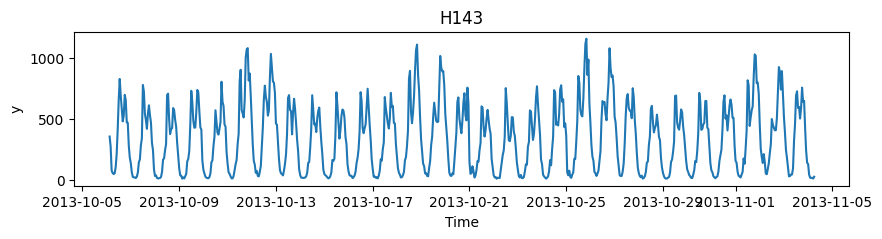

In [8]:
df_h143['time'] = pd.to_datetime(df_h143['time'])

plt.figure(figsize=(10, 2))

plt.plot(df_h143['time'], df_h143['y'], label='H143')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('H143')

plt.show()


In [9]:
# Aplicar la prueba de Dickey-Fuller
result = adfuller(df_h143["y"])

# Mostrar los resultados
print("Resultados de la Prueba de Dickey-Fuller Aumentada:")
print(f"Estadístico ADF: {result[0]}")
print(f"Valor p: {result[1]}")
print(f"Número de retardos usados: {result[2]}")
print(f"Número de observaciones: {result[3]}")
print("Valores críticos:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

# Interpretación del resultado
alpha = 0.05  # Nivel de significancia del 5%
if result[1] < alpha:
    print("\nConclusión: La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("\nConclusión: La serie NO es estacionaria (no se puede rechazar la hipótesis nula).")


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico ADF: -3.7970376746392724
Valor p: 0.0029377692888558934
Número de retardos usados: 20
Número de observaciones: 679
Valores críticos:
  1%: -3.4400174432106305
  5%: -2.8658060125001295
  10%: -2.569041777564251

Conclusión: La serie es estacionaria (se rechaza la hipótesis nula).


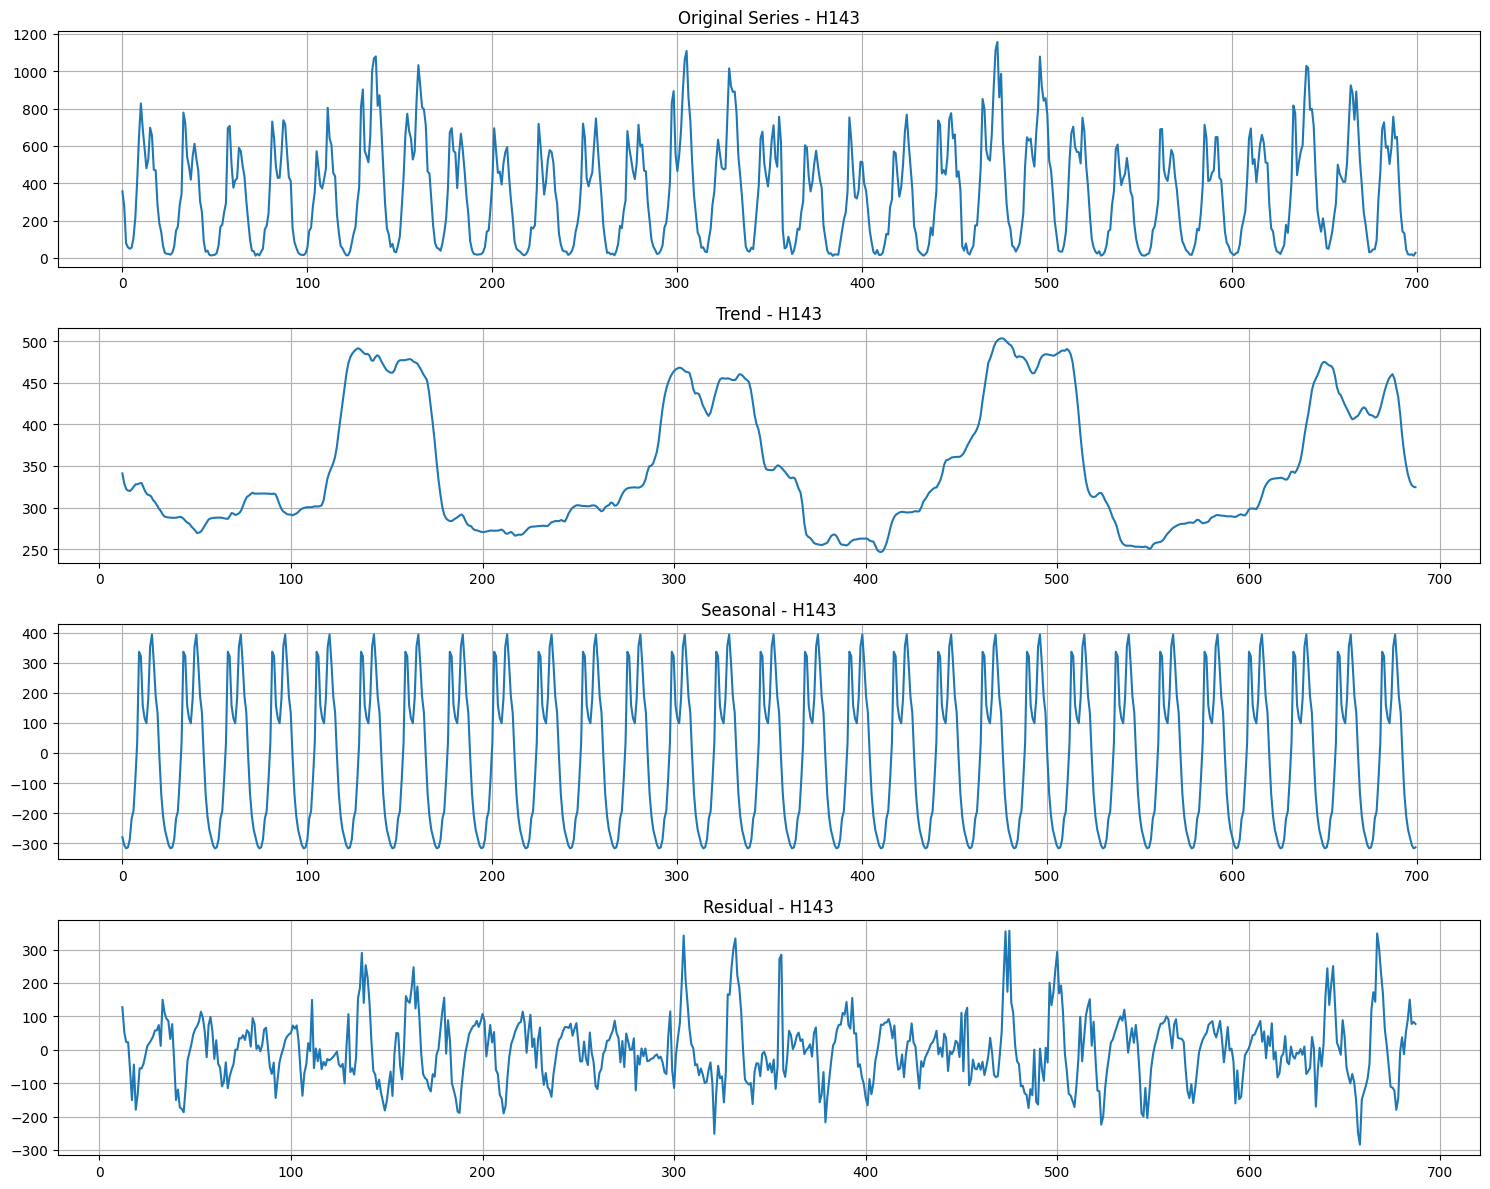

In [10]:
def plot_decomposition(series, series_name, period=24): #24 por que son por hora
    decomposition = seasonal_decompose(series, model='additive', period=period)

    # Crear subgráficos
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    titles = ["Original Series", "Trend", "Seasonal", "Residual"]
    components = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

    for ax, title, comp in zip(axes, titles, components):
        ax.plot(comp)
        ax.set_title(f"{title} - {series_name}")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Aplicar la descomposición estacional
plot_decomposition(df_h143["y"], "H143")


No parece tener tendencia alguna, se ven los mismos picos repetidamente en la parte de estacionalidad. El patrón estacional que se observa tan claramente parece corresponder a un ciclo diario, donde cada 24 unidades (horas) el patrón se repite. El test de dikcey fuller me dice que es una serie estacionaria. A mi parecer, por ya ser una serie estacionaria, no se necesita ninguna transformación.

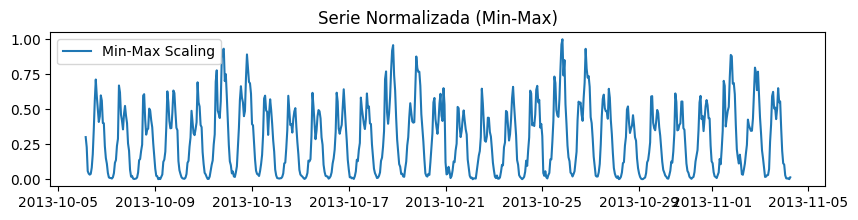

In [11]:
#normalizar los datos para las redes
scaler_minmax = MinMaxScaler()
df_h143['y_scaled'] = scaler_minmax.fit_transform(df_h143[['y']])

plt.figure(figsize=(10, 2))
plt.plot(df_h143['time'], df_h143['y_scaled'], label="Min-Max Scaling")
plt.title("Serie Normalizada (Min-Max)")
plt.legend()

## División


In [12]:
# Definir los tamaños de los conjuntos (por ejemplo, 70% para entrenamiento, 15% para validación y 15% para prueba)
train_size = int(len(df_h143) * 0.7)
val_size = int(len(df_h143) * 0.15) 
test_size = len(df_h143) - train_size - val_size

# Dividir la serie en entrenamiento, validación y prueba
train, val, test = df_h143[:train_size], df_h143[train_size:train_size+val_size], df_h143[train_size+val_size:]

# Verificar la división
print(f"Entrenamiento: {len(train)} | Validación: {len(val)} | Prueba: {len(test)}")


Entrenamiento: 489 | Validación: 105 | Prueba: 106


El horizonte para esta serie es 48, como todas las que me tocaron

In [13]:
#test["time"] = pd.to_datetime(test["time"])  

last_date = test["time"].iloc[-1]  # Última fecha en el conjunto de prueba
print(f"Última fecha de la prueba: {last_date}")


Última fecha de la prueba: 2013-11-04 06:00:00


In [14]:
horizon = 48

#fechas de predicción a partir de la última fecha del conjunto de prueba
prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]

print("Fechas de predicción:")
print(prediction_dates)
print(len(prediction_dates))


Fechas de predicción:
DatetimeIndex(['2013-11-04 07:00:00', '2013-11-04 08:00:00',
               '2013-11-04 09:00:00', '2013-11-04 10:00:00',
               '2013-11-04 11:00:00', '2013-11-04 12:00:00',
               '2013-11-04 13:00:00', '2013-11-04 14:00:00',
               '2013-11-04 15:00:00', '2013-11-04 16:00:00',
               '2013-11-04 17:00:00', '2013-11-04 18:00:00',
               '2013-11-04 19:00:00', '2013-11-04 20:00:00',
               '2013-11-04 21:00:00', '2013-11-04 22:00:00',
               '2013-11-04 23:00:00', '2013-11-05 00:00:00',
               '2013-11-05 01:00:00', '2013-11-05 02:00:00',
               '2013-11-05 03:00:00', '2013-11-05 04:00:00',
               '2013-11-05 05:00:00', '2013-11-05 06:00:00',
               '2013-11-05 07:00:00', '2013-11-05 08:00:00',
               '2013-11-05 09:00:00', '2013-11-05 10:00:00',
               '2013-11-05 11:00:00', '2013-11-05 12:00:00',
               '2013-11-05 13:00:00', '2013-11-05 14:00:00',
  

/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_24512/2986970953.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]


# Creación de modelos

In [15]:
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 48  # Horizonte de predicción
n_features = 1


In [16]:
# Aplicar la función de división
X_train, y_train = split_univariate_sequence(train['y_scaled'].values, n_steps)
X_val, y_val = split_univariate_sequence(val['y_scaled'].values, n_steps)
X_test, y_test = split_univariate_sequence(test['y_scaled'].values, n_steps)


In [17]:
# Ajustar la forma para CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

### CNN 1

In [18]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss = model.evaluate(X_test, y_test)
print(f'Error cuadrático medio en prueba: {loss}')

Epoch 1/50


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0657 - val_loss: 0.0115
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0052
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0044
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0032
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037 - val_loss: 0.0031


Explicacion cnn1



...

..

<Axes: >

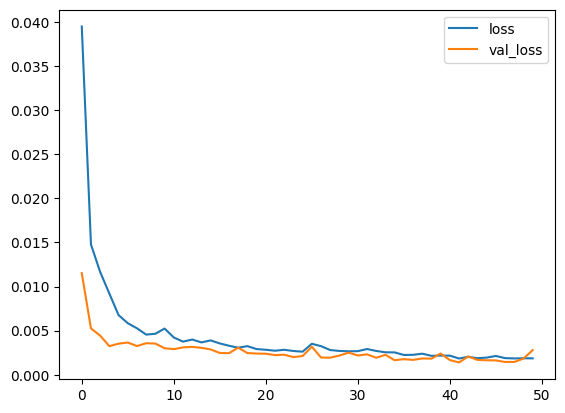

In [19]:
pd.DataFrame(history.history).plot()

In [20]:
scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1, 1))  

MinMaxScaler()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


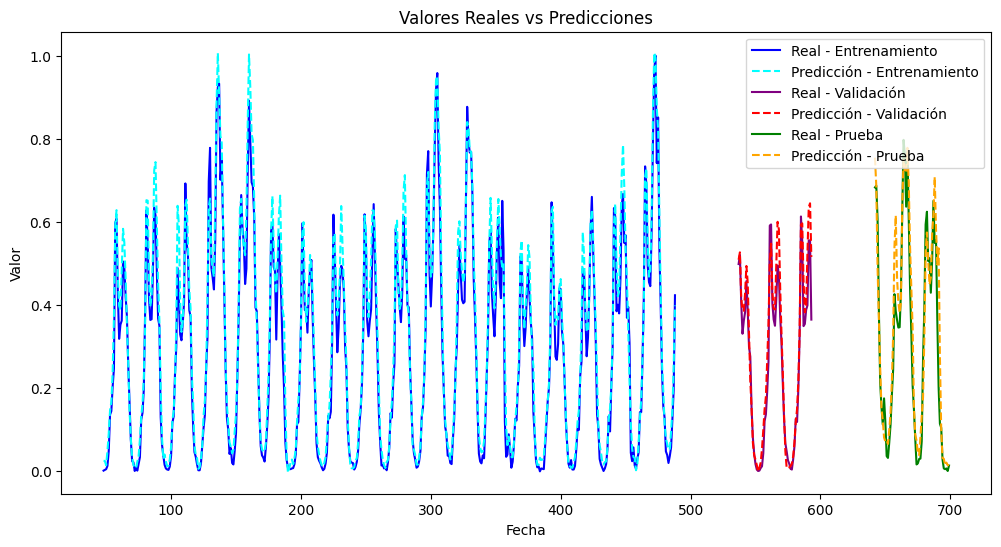

In [21]:

# Predicciones en el conjunto de entrenamiento, validación y prueba
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)  
y_test_pred = model.predict(X_test)

#quitar normalizacion
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)  
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

#  valores reales vs. predichos 
plt.figure(figsize=(12, 6))

# Reshape a 2D para aplicar inverse_transform
y_train_reshaped = y_train.reshape(-1, 1)  
plt.plot(train.index[n_steps:], scaler.inverse_transform(y_train_reshaped), label='Real - Entrenamiento', color='blue')
plt.plot(train.index[n_steps:], y_train_pred_inv, label='Predicción - Entrenamiento', color='cyan', linestyle='dashed')

# validación
y_val_reshaped = y_val.reshape(-1, 1)  
plt.plot(val.index[n_steps:], scaler.inverse_transform(y_val_reshaped), label='Real - Validación', color='purple')
plt.plot(val.index[n_steps:], y_val_pred_inv, label='Predicción - Validación', color='red', linestyle='dashed')

# prueba
y_test_reshaped = y_test.reshape(-1, 1)  
plt.plot(test.index[n_steps:], scaler.inverse_transform(y_test_reshaped), label='Real - Prueba', color='green')
plt.plot(test.index[n_steps:], y_test_pred_inv, label='Predicción - Prueba', color='orange', linestyle='dashed')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()


In [22]:
mae = mean_absolute_error(y_test_reshaped, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred_inv))
r2 = r2_score(y_test_reshaped, y_test_pred_inv)
mape = np.mean(np.abs((y_test_reshaped - y_test_pred_inv) / y_test_reshaped)) * 100


print(f"Evaluación del Modelo en Test:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 : {r2:.4f}")



Evaluación del Modelo en Test:
MAE : 0.0589
RMSE: 0.0839
R2 : 0.8811


### CNN 2

In [23]:
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss = model.evaluate(X_test, y_test)
print(f'Error cuadrático medio en prueba: {loss}')

Epoch 1/50


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0786 - val_loss: 0.0135
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.0067
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126 - val_loss: 0.0049
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0035
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0023
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - val_loss: 0.0034


<Axes: >

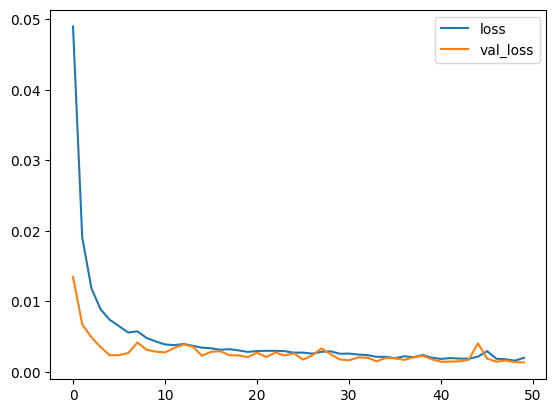

In [24]:
pd.DataFrame(history.history).plot()

In [25]:
scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1, 1))  

MinMaxScaler()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


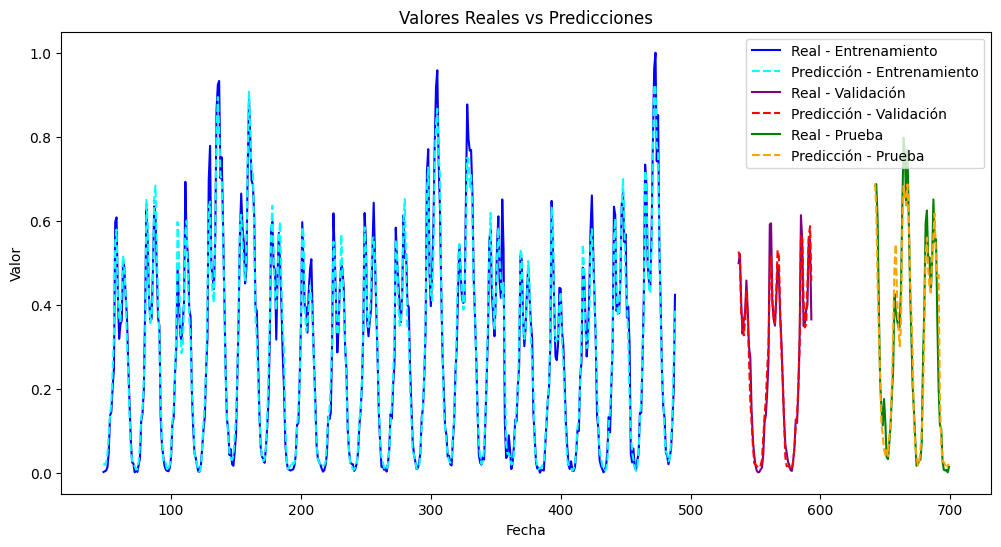

In [26]:

# Predicciones en el conjunto de entrenamiento, validación y prueba
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)  
y_test_pred = model.predict(X_test)

#quitar normalizacion
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred)  
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

#  valores reales vs. predichos 
plt.figure(figsize=(12, 6))

# Reshape a 2D para aplicar inverse_transform
y_train_reshaped = y_train.reshape(-1, 1)  
plt.plot(train.index[n_steps:], scaler.inverse_transform(y_train_reshaped), label='Real - Entrenamiento', color='blue')
plt.plot(train.index[n_steps:], y_train_pred_inv, label='Predicción - Entrenamiento', color='cyan', linestyle='dashed')

# validación
y_val_reshaped = y_val.reshape(-1, 1)  
plt.plot(val.index[n_steps:], scaler.inverse_transform(y_val_reshaped), label='Real - Validación', color='purple')
plt.plot(val.index[n_steps:], y_val_pred_inv, label='Predicción - Validación', color='red', linestyle='dashed')

# prueba
y_test_reshaped = y_test.reshape(-1, 1)  
plt.plot(test.index[n_steps:], scaler.inverse_transform(y_test_reshaped), label='Real - Prueba', color='green')
plt.plot(test.index[n_steps:], y_test_pred_inv, label='Predicción - Prueba', color='orange', linestyle='dashed')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Valores Reales vs Predicciones')
plt.legend()
plt.show()


In [27]:
mae = mean_absolute_error(y_test_reshaped, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred_inv))
r2 = r2_score(y_test_reshaped, y_test_pred_inv)
mape = np.mean(np.abs((y_test_reshaped - y_test_pred_inv) / y_test_reshaped)) * 100

print(f"Evaluación del Modelo en Test:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 : {r2:.4f}")



Evaluación del Modelo en Test:
MAE : 0.0489
RMSE: 0.0689
R2 : 0.9198


Expliacion cnn2

....




....

### Cnn 3

In [28]:
model3 = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),  # Evita el sobreajuste

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    
    Dense(50, activation='relu'),
    
    Dense(1)
])

optimizer = Adam(learning_rate=0.001) 
model3.compile(optimizer=optimizer, loss='mse')

history = model3.fit(
    X_train, y_train, 
    epochs=100, batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=1
)

loss = model3.evaluate(X_test, y_test)
print(f'Error cuadrático medio en prueba: {loss}')

Epoch 1/100


/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1076 - val_loss: 0.0239
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324 - val_loss: 0.0122
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.0089
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0062
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0060
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0041
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.0050
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0030
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0032
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0027
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0030
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_lo

Explicación cnn3

<Axes: >

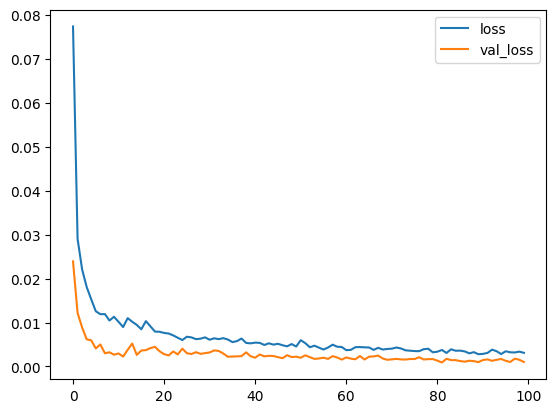

In [29]:
pd.DataFrame(history.history).plot()

In [30]:
# predicciones
y_train_pred = model3.predict(X_train)
y_val_pred = model3.predict(X_val) 
y_test_pred = model3.predict(X_test)

# quitar normalizacion
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_val_pred_inv = scaler.inverse_transform(y_val_pred) 
y_test_pred_inv = scaler.inverse_transform(y_test_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [31]:
mae = mean_absolute_error(y_test_reshaped, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred_inv))
r2 = r2_score(y_test_reshaped, y_test_pred_inv)
mape = np.mean(np.abs((y_test_reshaped - y_test_pred_inv) / y_test_reshaped)) * 100

print(f"Evaluación del Modelo en Test:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 : {r2:.4f}")


Evaluación del Modelo en Test:
MAE : 0.0792
RMSE: 0.1044
R2 : 0.8158


### MLP1

In [32]:
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [33]:
window_size = 24 #que vaya checando ppor dia

X_train, y_train = split_univariate_sequence(train['y_scaled'].values, window_size)
X_val, y_val = split_univariate_sequence(val['y_scaled'].values, window_size)
X_test, y_test = split_univariate_sequence(test['y_scaled'].values, window_size)




In [34]:
n_steps = 24
model1 = keras.Sequential([
    keras.layers.Input(shape=(n_steps,)),  
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dense(1)
])

model1.compile(optimizer='adam', 
               loss='mae', 
               metrics=[tf.metrics.MeanAbsolutePercentageError(), tf.metrics.MeanSquaredError()])

model1.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │         2,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601 (10.16 KB)

 Trainable params: 2,601 (10.16 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Entrenar el modelo con los datos de entrenamiento
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4355 - mean_absolute_percentage_error: 165303.9688 - mean_squared_error: 0.3018 - val_loss: 0.1633 - val_mean_absolute_percentage_error: 1431.3843 - val_mean_squared_error: 0.0381
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1647 - mean_absolute_percentage_error: 1034380.8750 - mean_squared_error: 0.0399 - val_loss: 0.0876 - val_mean_absolute_percentage_error: 316.7048 - val_mean_squared_error: 0.0157
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1022 - mean_absolute_percentage_error: 42456.6680 - mean_squared_error: 0.0195 - val_loss: 0.0838 - val_mean_absolute_percentage_error: 169.0010 - val_mean_squared_error: 0.0149
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0807 - mean_absolute_percentage_error: 31113.2090 - mean_squared_error: 0.0126 - val_loss: 0.0878 - val_mean_absolute_percentage_error: 199.3221 - val_mean_squared_error: 0.0155
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [36]:
# Evaluar el modelo con los datos de prueba
test_loss, test_mape, test_mse = model1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test MAPE: {test_mape}")
print(f"Test MSE: {test_mse}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0518 - mean_absolute_percentage_error: 34.5084 - mean_squared_error: 0.0050
Test Loss: 0.051400475203990936
Test MAPE: 43.31734085083008
Test MSE: 0.0050112116150557995


In [37]:
#  predicciones sobre el conjunto de prueba
predictions = model1.predict(X_test)

print(predictions[:5])  #ver 5 pred


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[[0.39012867]
 [0.31751812]
 [0.25754115]
 [0.14229022]
 [0.07180642]]


<Axes: >

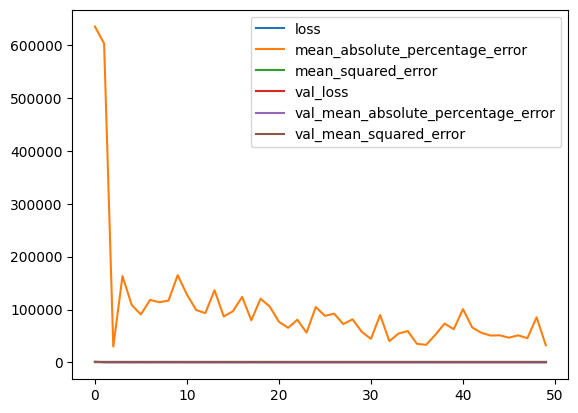

In [38]:
# Analizar función de pérdida
pd.DataFrame(history.history).plot()

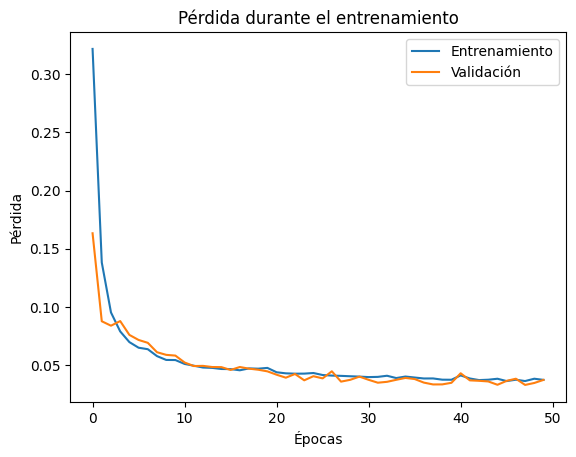

In [39]:
#ya que no se vio en la anterior
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()



In [40]:
predictions = model1.predict(X_test)

r2 = r2_score(y_test, predictions)
print(f"R²: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R²: 0.9224585757057376


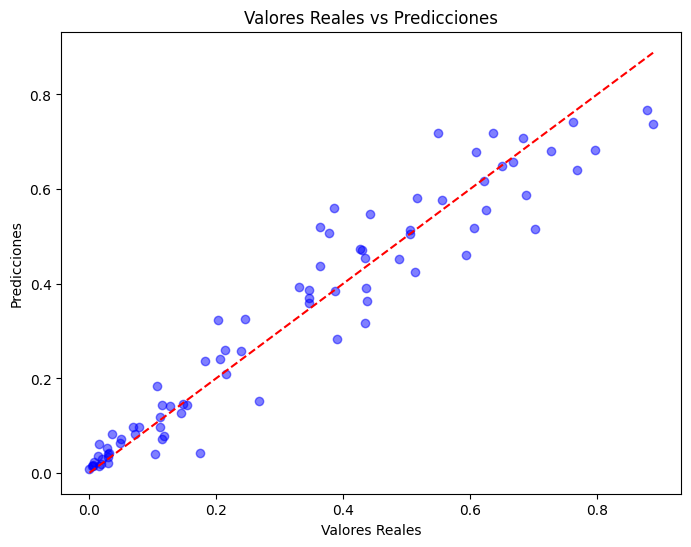

In [41]:
# Graficar reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea de igualdad
plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


### MLP 2

In [42]:
n_steps = 24
model1 = keras.Sequential([
    keras.layers.Input(shape=(n_steps,)),  
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dense(1)
])

model1.compile(optimizer='adam', 
               loss='mae', 
               metrics=[tf.metrics.MeanAbsolutePercentageError(), tf.metrics.MeanSquaredError()])

model1.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 100)            │         2,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601 (10.16 KB)

 Trainable params: 2,601 (10.16 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Entrenar el modelo con los datos de entrenamiento
history = model1.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), verbose=1)


Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1250 - mean_absolute_percentage_error: 203949.5000 - mean_squared_error: 0.0265 - val_loss: 0.0816 - val_mean_absolute_percentage_error: 214.4074 - val_mean_squared_error: 0.0118
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0790 - mean_absolute_percentage_error: 17070.4180 - mean_squared_error: 0.0114 - val_loss: 0.0578 - val_mean_absolute_percentage_error: 92.0719 - val_mean_squared_error: 0.0071
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0580 - mean_absolute_percentage_error: 73427.1641 - mean_squared_error: 0.0075 - val_loss: 0.0567 - val_mean_absolute_percentage_error: 131.7405 - val_mean_squared_error: 0.0072
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0546 - mean_absolute_percentage_error: 11279.3369 - mean_squared_error: 0.0065 - val_loss: 0.0578 - val_mean_absolute_percentage_error: 131.2213 - val_mean_squared_error: 0.0082
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

In [44]:
# Evaluar el modelo con los datos de prueba
test_loss, test_mape, test_mse = model1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test MAPE: {test_mape}")
print(f"Test MSE: {test_mse}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0506 - mean_absolute_percentage_error: 36.9424 - mean_squared_error: 0.0043
Test Loss: 0.05236497148871422
Test MAPE: 41.86314010620117
Test MSE: 0.004596072714775801


In [45]:
predictions = model1.predict(X_test)

print(predictions[:5])  #ver 5 pred

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepWARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x16c6d3ba0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[[0.41205138]
 [0.30821905]
 [0.25049827]
 [0.11433504]
 [0.05718439]]


In [46]:
predictions = model1.predict(X_test)

r2 = r2_score(y_test, predictions)
print(f"R²: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R²: 0.9288822612559028


### MLP 3

In [47]:
n_steps = 24
model1 = keras.Sequential([
    keras.layers.Input(shape=(n_steps,)),  
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dense(1)
])

model1.compile(optimizer='SGD', 
               loss='mae', 
               metrics=[tf.metrics.MeanAbsolutePercentageError(), tf.metrics.MeanSquaredError()])

model1.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 100)            │         2,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601 (10.16 KB)

 Trainable params: 2,601 (10.16 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Entrenar el modelo con los datos de entrenamiento
history = model1.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), verbose=1)


Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2846 - mean_absolute_percentage_error: 530563.0625 - mean_squared_error: 0.1233 - val_loss: 0.1755 - val_mean_absolute_percentage_error: 576.2549 - val_mean_squared_error: 0.0446
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1907 - mean_absolute_percentage_error: 14102.4170 - mean_squared_error: 0.0631 - val_loss: 0.1095 - val_mean_absolute_percentage_error: 201.5538 - val_mean_squared_error: 0.0202
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1265 - mean_absolute_percentage_error: 802.8312 - mean_squared_error: 0.0307 - val_loss: 0.0864 - val_mean_absolute_percentage_error: 289.4745 - val_mean_squared_error: 0.0116
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1121 - mean_absolute_percentage_error: 97620.8828 - mean_squared_error: 0.0237 - val_loss: 0.0767 - val_mean_absolute_percentage_error: 301.4750 - val_mean_squared_error: 0.0090
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [49]:
# Evaluar el modelo con los datos de prueba
test_loss, test_mape, test_mse = model1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test MAPE: {test_mape}")
print(f"Test MSE: {test_mse}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0580 - mean_absolute_percentage_error: 44.3842 - mean_squared_error: 0.0067
Test Loss: 0.05741414055228233
Test MAPE: 55.590850830078125
Test MSE: 0.00648181326687336


In [50]:
predictions = model1.predict(X_test)

print(predictions[:5])  #ver 5 pred

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x175d2cea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[[0.40691978]
 [0.29924285]
 [0.22736962]
 [0.12227979]
 [0.05503117]]


In [51]:
predictions = model1.predict(X_test)

r2 = r2_score(y_test, predictions)
print(f"R²: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R²: 0.8997030852891542


### LSTM 1

In [52]:
# Definir n_steps (ventana de tiempo)
n_steps = 24

# Aplicar la función para cada subconjunto (entrenamiento, validación y prueba)
X_train, y_train = split_univariate_sequence(train['y_scaled'].values, n_steps)
X_val, y_val = split_univariate_sequence(val['y_scaled'].values, n_steps)
X_test, y_test = split_univariate_sequence(test['y_scaled'].values, n_steps)

# Redimensionar para la entrada del LSTM (samples, timesteps, features)
n_features = 1  # Solo tenemos una variable
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))


In [53]:

# Definir el modelo LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, n_features)),  # Capa LSTM
    Dense(1)  # Capa de salida
])

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model_lstm.compile(optimizer='adam', loss='mse')

In [55]:
model_lstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Entrenar el modelo
history = model_lstm.fit(
    X_train, y_train, 
    epochs=50, batch_size=16, 
    validation_data=(X_val, y_val)
)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0949 - val_loss: 0.0352
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - val_loss: 0.0292
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391 - val_loss: 0.0230
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302 - val_loss: 0.0560
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281 - val_loss: 0.0125
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167 - val_loss: 0.0097
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0069
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0093
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0102
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0138
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0067
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - val_lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


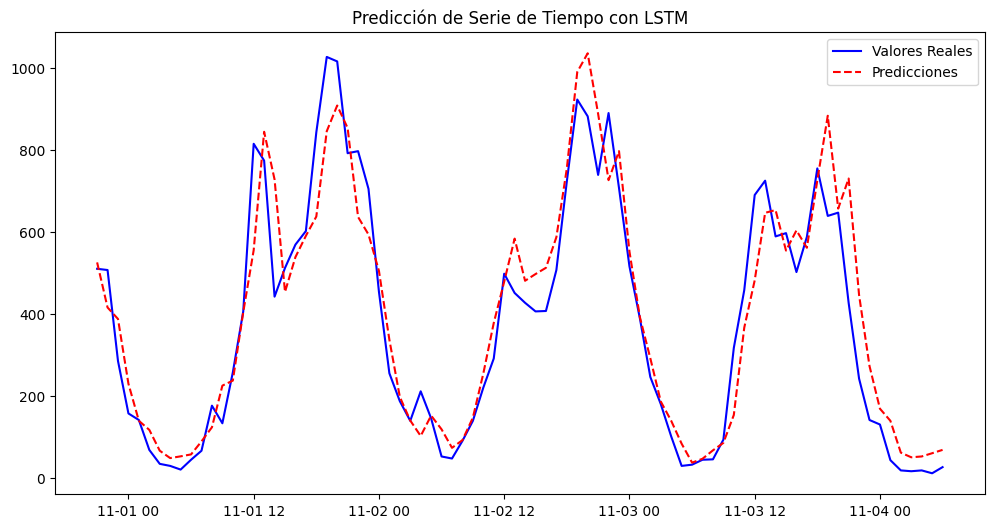

In [57]:
y_pred = model_lstm.predict(X_test)

# Desescalar las predicciones y valores reales
y_pred_rescaled = scaler_minmax.inverse_transform(y_pred)
y_test_rescaled = scaler_minmax.inverse_transform(y_test.reshape(-1, 1))

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test['time'].iloc[n_steps:], y_test_rescaled, label="Valores Reales", color="blue")
plt.plot(test['time'].iloc[n_steps:], y_pred_rescaled, label="Predicciones", color="red", linestyle="dashed")
plt.legend()
plt.title("Predicción de Serie de Tiempo con LSTM")
plt.show()

In [58]:
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled) ** 2))


print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.8794
MAE: 73.6683
RMSE: 101.0743


<Axes: >

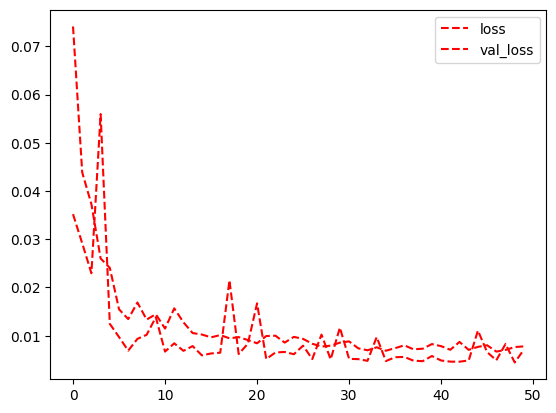

In [59]:
pd.DataFrame(history.history).plot(style='r--')

### LSTM 2

In [60]:
model_lstm = Sequential([
    keras.layers.Input(shape=(n_steps, n_features)),
    LSTM(50, activation='relu', return_sequences=True),  # Primera capa LSTM con return_sequences=True
    Dropout(0.2),  # Regularización
    LSTM(30, activation='relu'),  # Segunda capa LSTM
    Dense(1)  # Capa de salida
])

In [61]:
model_lstm.compile(optimizer='adam', loss='mse')

In [62]:
model_lstm.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,151 (78.71 KB)

 Trainable params: 20,151 (78.71 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
history = model_lstm.fit(
    X_train, y_train, 
    epochs=200, batch_size=16, 
    validation_data=(X_val, y_val)
)


Epoch 1/200


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1178 - val_loss: 0.0426
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0687 - val_loss: 0.0406
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0665 - val_loss: 0.0372
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0529 - val_loss: 0.0340
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.0158
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - val_loss: 0.0272
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440 - val_loss: 0.0237
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - val_loss: 0.0186
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - val_loss: 0.0161
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_loss: 0.0262
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - val_loss: 0.0158
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


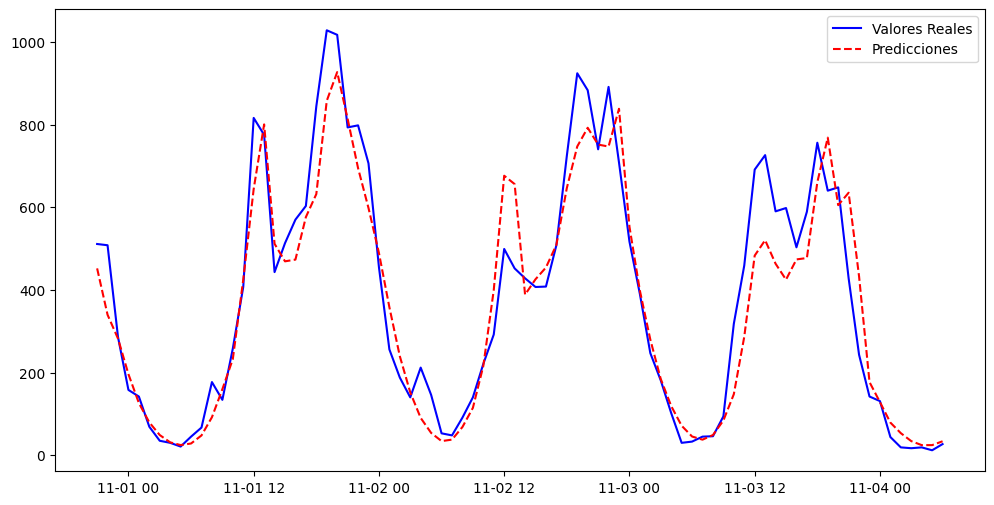

In [64]:
y_pred = model_lstm  .predict(X_test)

# Desescalar las predicciones y valores reales
y_pred_rescaled = scaler_minmax.inverse_transform(y_pred)
y_test_rescaled = scaler_minmax.inverse_transform(y_test.reshape(-1, 1))

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test['time'].iloc[n_steps:n_steps+len(y_test_rescaled)], y_test_rescaled, label="Valores Reales", color="blue")
plt.plot(test['time'].iloc[n_steps:n_steps+len(y_pred_rescaled)], y_pred_rescaled, label="Predicciones", color="red", linestyle="dashed")
plt.legend()
plt.show()


In [65]:
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled) ** 2))


print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.8956
MAE: 67.6161
RMSE: 94.0706


<Axes: >

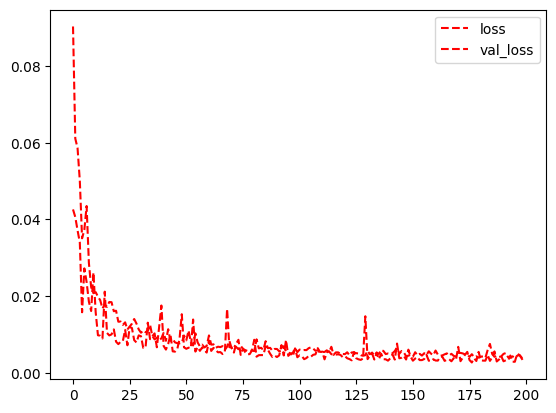

In [66]:
pd.DataFrame(history.history).plot(style='r--')

### LSTM 3

In [67]:
model_lstm = Sequential([
    keras.layers.Input(shape=(n_steps, n_features)),
    LSTM(50, activation='tanh', return_sequences=True),  # Primera capa LSTM con return_sequences=True
    Dropout(0.2),  # Regularización
    LSTM(30, activation='tanh'),  # Segunda capa LSTM
    Dense(1)  # Capa de salida
])

In [68]:
model_lstm.compile(optimizer='adam', loss='mse')

In [69]:
model_lstm.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,151 (78.71 KB)

 Trainable params: 20,151 (78.71 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model_lstm.fit(
    X_train, y_train, 
    epochs=200, batch_size=16, 
    validation_data=(X_val, y_val)
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0887 - val_loss: 0.0401
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0568 - val_loss: 0.0303
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - val_loss: 0.0157
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - val_loss: 0.0170
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0144
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.0142
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0127
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0166
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 10/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 11/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.0130
Epoch 12/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


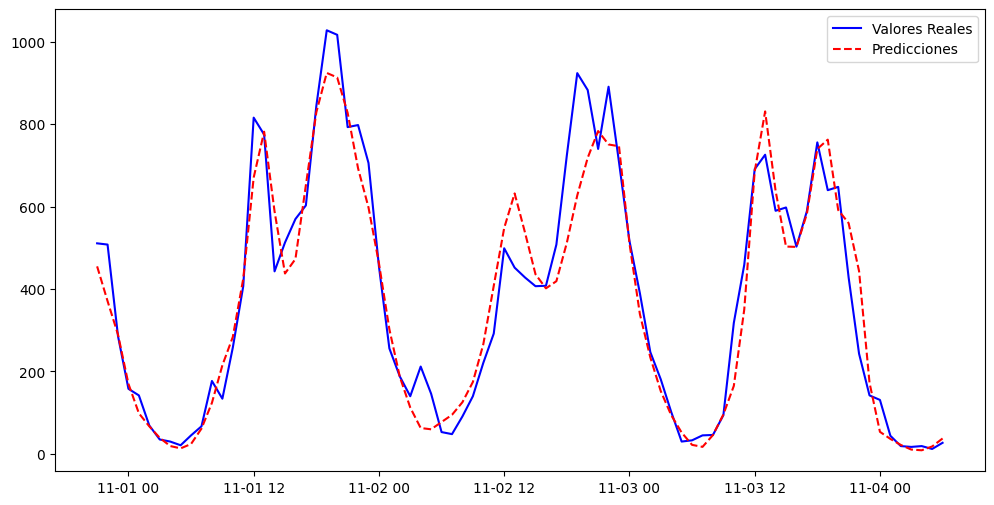

In [71]:
y_pred = model_lstm  .predict(X_test)

# Desescalar las predicciones y valores reales
y_pred_rescaled = scaler_minmax.inverse_transform(y_pred)
y_test_rescaled = scaler_minmax.inverse_transform(y_test.reshape(-1, 1))

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(test['time'].iloc[n_steps:n_steps+len(y_test_rescaled)], y_test_rescaled, label="Valores Reales", color="blue")
plt.plot(test['time'].iloc[n_steps:n_steps+len(y_pred_rescaled)], y_pred_rescaled, label="Predicciones", color="red", linestyle="dashed")
plt.legend()

In [72]:
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled) ** 2))


print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.9168
MAE: 58.7393
RMSE: 83.9633


<Axes: >

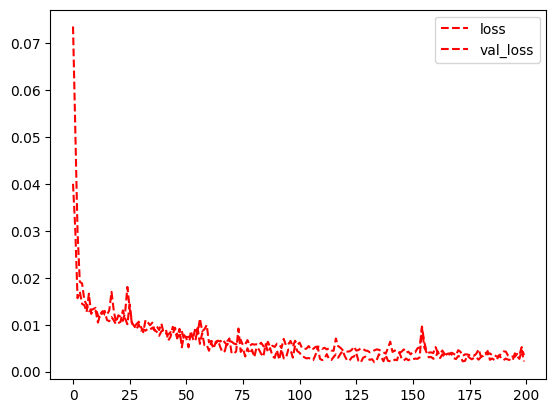

In [73]:
pd.DataFrame(history.history).plot(style='r--')

In [74]:
# Seleccionamos los últimos 'n_steps' datos de test (última secuencia)
input_seq = test[['y_scaled']].iloc[-n_steps:].values

# Reshape para la entrada del modelo
input_seq = input_seq.reshape((1, n_steps, 1))  # (1, n_steps, 1)



In [75]:
# Predecir el siguiente paso (1 paso adelante)
predictions = []

for i in range(48):  # Queremos hacer una predicción para 48 horas
    # Hacer la predicción
    pred = model_lstm.predict(input_seq, verbose=0)
    
    # Almacenar la predicción
    predictions.append(pred[0, 0])
    
    # Actualizar la secuencia de entrada para la siguiente predicción
    input_seq = np.append(input_seq[:, 1:, :], pred.reshape(1, 1, 1), axis=1)


In [76]:
predictions_rescaled = scaler_minmax.inverse_transform(np.array(predictions).reshape(-1, 1))

# Generar las predicciones con el tiempo correspondiente
future_times = pd.date_range(start=test['time'].iloc[-1], periods=49, freq='H')[1:]

forecast_df = pd.DataFrame({
    'time': future_times,
    'predicted': predictions_rescaled.flatten()
})

# Ver las primeras predicciones
print(forecast_df.head())


                 time   predicted
0 2013-11-04 07:00:00   70.662750
1 2013-11-04 08:00:00  123.299484
2 2013-11-04 09:00:00  193.350845
3 2013-11-04 10:00:00  300.445343
4 2013-11-04 11:00:00  516.335327


/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_24512/890044726.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_times = pd.date_range(start=test['time'].iloc[-1], periods=49, freq='H')[1:]


In [77]:
# Para graficar correctamente, necesitamos revertir el escalado de los valores reales también
y_real_rescaled = scaler_minmax.inverse_transform(df_h143['y_scaled'].values.reshape(-1, 1))


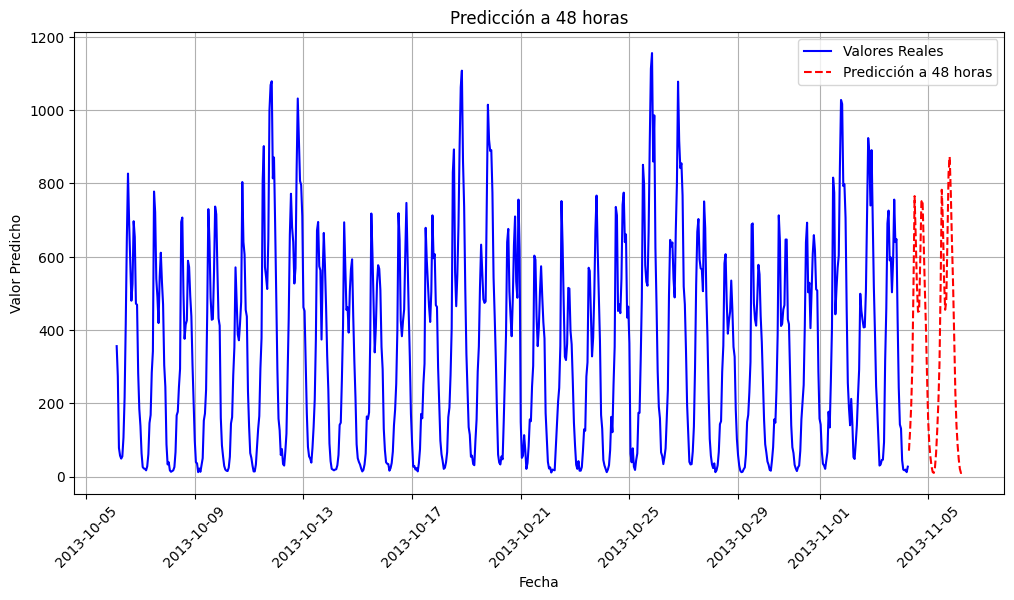

In [78]:
# Graficamos los valores reales y las predicciones
plt.figure(figsize=(12, 6))

# Graficar los valores reales
plt.plot(df_h143['time'], y_real_rescaled, label='Valores Reales', color='blue')

# Graficar las predicciones a futuro
plt.plot(forecast_df['time'], forecast_df['predicted'], label='Predicción a 48 horas', color='red', linestyle='--')

plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor Predicho')
plt.title('Predicción a 48 horas')

# Mejorar visualización con rotación de fechas y grid
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### CNN/LSTM

In [79]:
# Convertir la serie a array
raw_seq = train['y_scaled'].values

In [80]:
n_steps = 4
n_features = 1
n_seq = 2
n_steps_sub = n_steps // n_seq  # Número de pasos por sub-secuencia

In [81]:
X_train, y_train = split_univariate_sequence(raw_seq, n_steps)
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps_sub, n_features))


In [82]:
model_cnnlstm = Sequential([
    TimeDistributed(Conv1D(64, 1, activation='relu'), input_shape=(n_seq, n_steps_sub, n_features)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu'),
    Dense(1)
])

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
model_cnnlstm.compile(optimizer='RMSprop', loss='mse')
history = model_cnnlstm.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1172 - val_loss: 0.0665
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0508 - val_loss: 0.0366
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297 - val_loss: 0.0333
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 - val_loss: 0.0322
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - val_loss: 0.0311
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259 - val_loss: 0.0301
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - val_loss: 0.0328
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0267 - val_loss: 0.0295
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262 - val_loss: 0.0285
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - val_loss: 0.0271
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - val_loss: 0.0266
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [84]:
model_cnnlstm.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 2, 2, 64)       │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 2, 1, 64)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 2, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,360 (181.10 KB)

 Trainable params: 23,179 (90.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,181 (90.55 KB)

<Axes: >

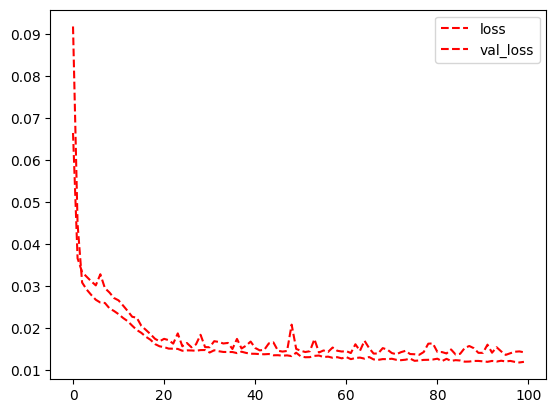

In [85]:
pd.DataFrame(history.history).plot(style='r--')

In [86]:
# Calcular métricas de evaluación
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled) ** 2))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.9168
RMSE: 83.9633
MAE: 58.7393


### CNN-LSTM 2

In [87]:
n_steps = 6
n_features = 1
n_seq = 3
n_steps_sub = n_steps // n_seq 

In [88]:
X_train, y_train = split_univariate_sequence(raw_seq, n_steps)
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps_sub, n_features))


In [89]:
model_cnnlstm = Sequential([
    # Primera capa convolucional
    TimeDistributed(Conv1D(64, kernel_size=1, activation='relu'), input_shape=(n_seq, n_steps_sub, n_features)),
    TimeDistributed(MaxPooling1D(pool_size=1)),

    # Segunda capa convolucional
    TimeDistributed(Conv1D(128, kernel_size=1, activation='relu')),
    TimeDistributed(MaxPooling1D(pool_size=1)),

    # Aplanado para la entrada a LSTM
    TimeDistributed(Flatten()),

    # Capa LSTM
    LSTM(50, activation='relu'),

    # Capa densa de salida
    Dense(1)
])

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [90]:
model_cnnlstm.compile(optimizer='RMSprop', loss='mse')
history = model_cnnlstm.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0682 - val_loss: 0.0454
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342 - val_loss: 0.0368
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.0406
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306 - val_loss: 0.0325
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - val_loss: 0.0311
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 - val_loss: 0.0394
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.0225
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0170
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0495
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.0359
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0757
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

<Axes: >

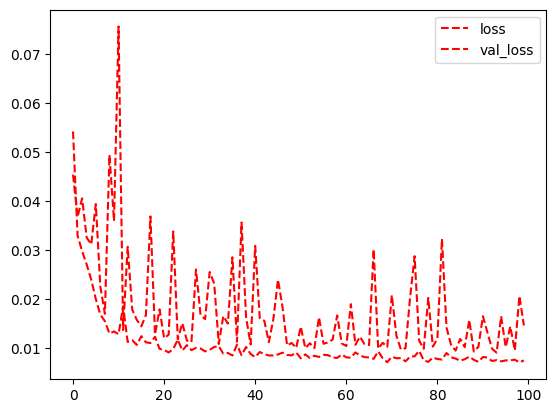

In [91]:
pd.DataFrame(history.history).plot(style='r--')

In [92]:
# Calcular métricas de evaluación
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled) ** 2))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.9168
RMSE: 83.9633
MAE: 58.7393


### CNN-LSTM 3

In [93]:
n_steps = 4
n_features = 1
n_seq = 2
n_steps_sub = n_steps // n_seq 

In [94]:
model_cnnlstm = Sequential([
    # Primera capa convolucional
    TimeDistributed(Conv1D(64, kernel_size=1, activation='tanh'), input_shape=(n_seq, n_steps_sub, n_features)),
    TimeDistributed(MaxPooling1D(pool_size=1)),

    # Segunda capa convolucional
    TimeDistributed(Conv1D(128, kernel_size=1, activation='tanh')),
    TimeDistributed(MaxPooling1D(pool_size=1)),

    # Aplanado para la entrada a LSTM
    TimeDistributed(Flatten()),

    # Capa LSTM
    LSTM(50, activation='relu'),

    # Capa densa de salida
    Dense(1)
])

/Users/maripau/Desktop/ITESO/No lineales/EXAMEN2/examen2_venv/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [96]:
model_cnnlstm.compile(optimizer='RMSprop', loss='mse')
history = model_cnnlstm.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0075 - val_loss: 0.0160
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0178
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0109
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0131
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0121
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0144
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0129
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0088
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0139
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0136
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

<Axes: >

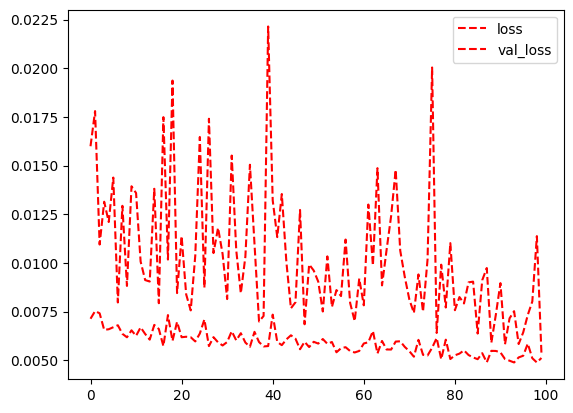

In [97]:
pd.DataFrame(history.history).plot(style='r--')

In [98]:
# Calcular métricas de evaluación
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled) ** 2))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.9168
RMSE: 83.9633
MAE: 58.7393


# H174

In [186]:

# Definir la fecha de inicio
start_date = pd.to_datetime("17-05-10 12:00", format="%d-%m-%y %H:%M")

# Crear un rango de fechas con una hora de diferencia para cada fila de H143
index = pd.date_range(start=start_date, periods=len(df_t["H174"]), freq="H")

# Asignar el nuevo índice de tiempo a la serie
df_h174 = df_t["H174"].copy()
df_h174.index = index

df_h174 = pd.DataFrame({"time": index, "y": df_t["H174"].values})
df_h174 = df_h174.dropna(subset=['y'])

df_h174


/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/2996351564.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start_date, periods=len(df_t["H174"]), freq="H")


time     y
0   2010-05-17 12:00:00  12.2
1   2010-05-17 13:00:00  11.4
2   2010-05-17 14:00:00  11.1
3   2010-05-17 15:00:00  10.7
4   2010-05-17 16:00:00  10.4
..                  ...   ...
955 2010-06-26 07:00:00  24.4
956 2010-06-26 08:00:00  24.9
957 2010-06-26 09:00:00  25.3
958 2010-06-26 10:00:00  25.6
959 2010-06-26 11:00:00  25.3

[960 rows x 2 columns]

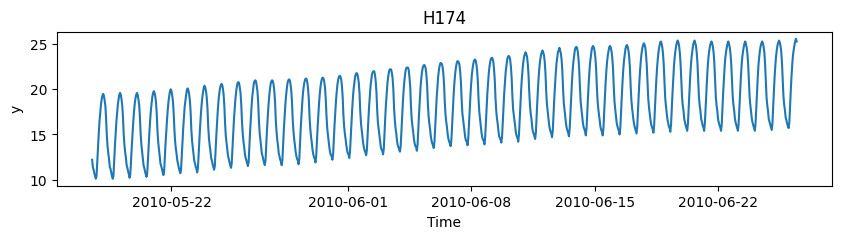

In [187]:
df_h174['time'] = pd.to_datetime(df_h174['time'])

plt.figure(figsize=(10, 2))

plt.plot(df_h174['time'], df_h174['y'], label='H143')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('H174')

plt.show()


In [ ]:
# Aplicar la prueba de Dickey-Fuller
result = adfuller(df_h174["y"])

# Mostrar los resultados
print("Resultados de la Prueba de Dickey-Fuller Aumentada:")
print(f"Estadístico ADF: {result[0]}")
print(f"Valor p: {result[1]}")
print(f"Número de retardos usados: {result[2]}")
print(f"Número de observaciones: {result[3]}")
print("Valores críticos:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

# Interpretación del resultado
alpha = 0.05  # Nivel de significancia del 5%
if result[1] < alpha:
    print("\nConclusión: La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("\nConclusión: La serie NO es estacionaria (no se puede rechazar la hipótesis nula).")


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico ADF: -9.091742564373343
Valor p: 3.807932672163276e-15
Número de retardos usados: 22
Número de observaciones: 937
Valores críticos:
  1%: -3.4373481911362997
  5%: -2.864629502968925
  10%: -2.56841503507527

Conclusión: La serie es estacionaria (se rechaza la hipótesis nula).


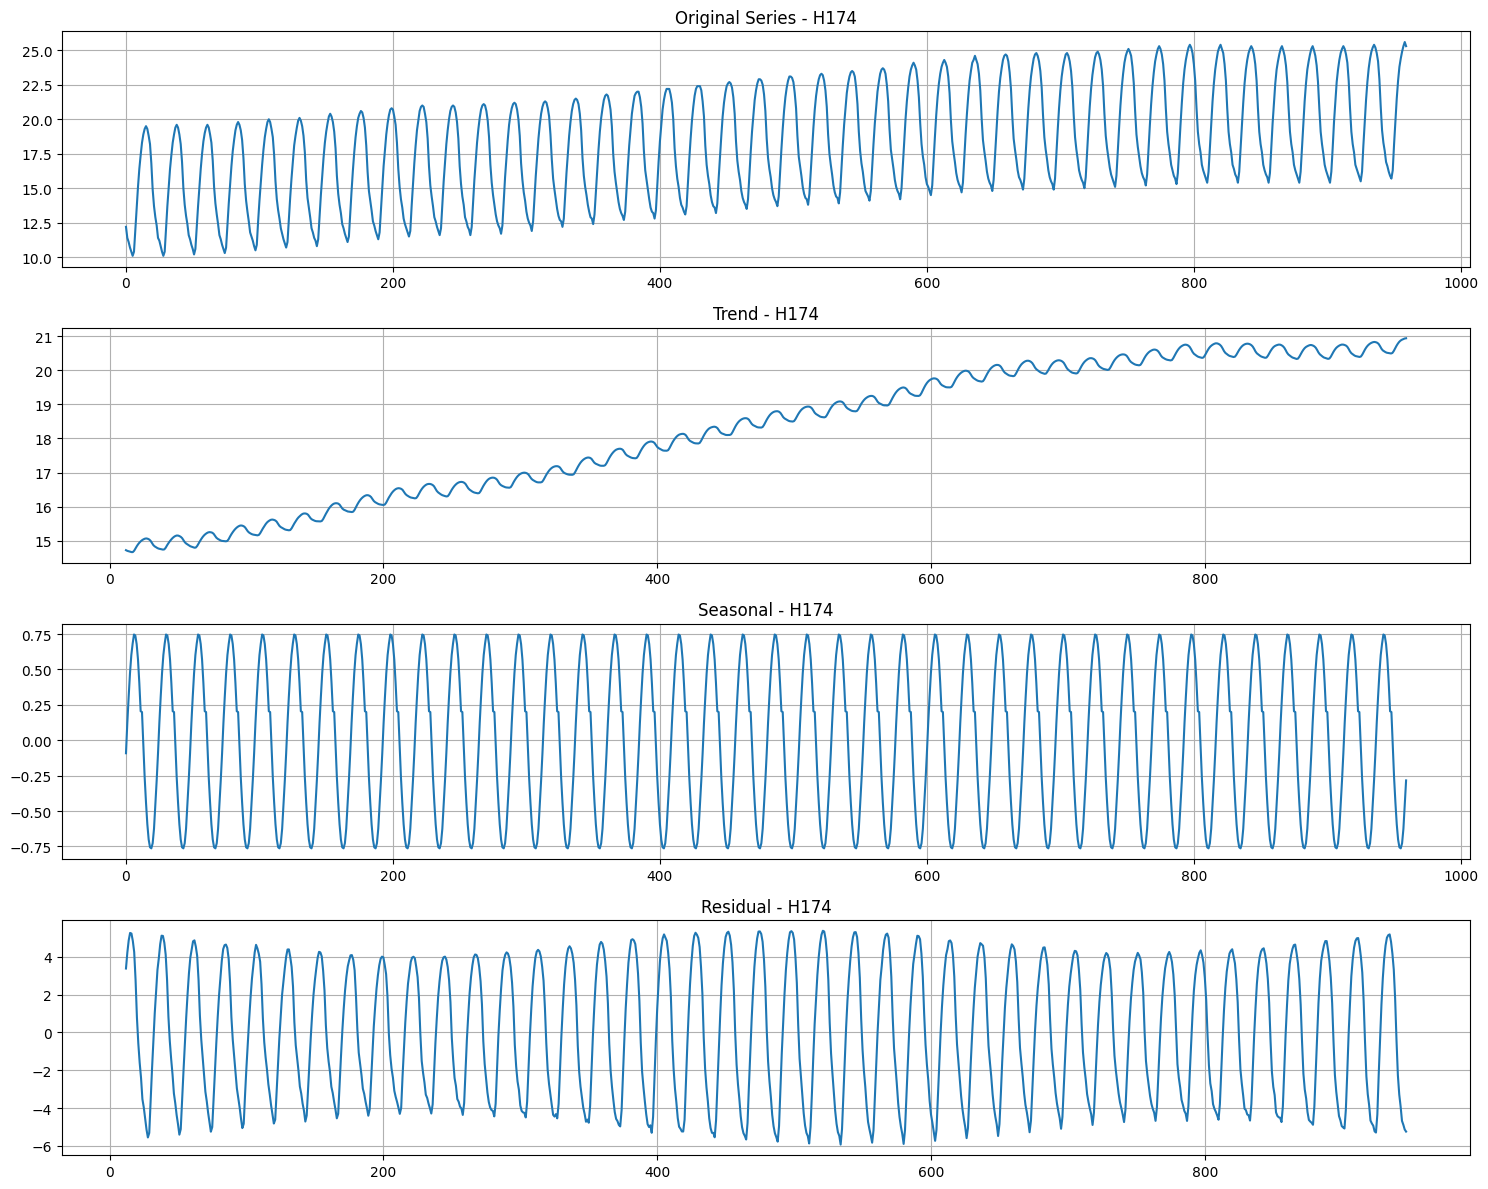

In [189]:
def plot_decomposition(series, series_name, period=24): #24 por que son por hora
    decomposition = seasonal_decompose(series, model='additive', period=period)

    # Crear subgráficos
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    titles = ["Original Series", "Trend", "Seasonal", "Residual"]
    components = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

    for ax, title, comp in zip(axes, titles, components):
        ax.plot(comp)
        ax.set_title(f"{title} - {series_name}")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Aplicar la descomposición estacional
plot_decomposition(df_h174["y"], "H174")


Esta tiene una tendencia a la alta un poco clara, aunque no es muy pronunciada. En la de estacionalidad, tiene ciclos muy regulares, y el test de dickey fuller dice que es estacional. Tiene residuos que parecen ser ruido blanco. Aunque, la serie tiene una pequeña tendencia, considero que es minima. Intentare hacer el modelo primero sin diferenciación, y si los resultados no son buenos lo intentaré con diferenciación.  

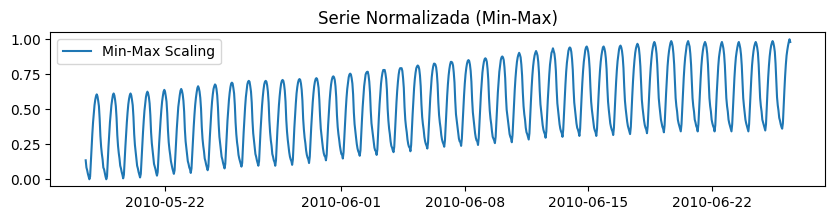

In [190]:
#normalizar los datos para las redes
scaler_minmax = MinMaxScaler()
df_h174['y_scaled'] = scaler_minmax.fit_transform(df_h174[['y']])

plt.figure(figsize=(10, 2))
plt.plot(df_h174['time'], df_h174['y_scaled'], label="Min-Max Scaling")
plt.title("Serie Normalizada (Min-Max)")
plt.legend()

# Division

In [191]:
# Definir los tamaños de los conjuntos (por ejemplo, 70% para entrenamiento, 15% para validación y 15% para prueba)
train_size = int(len(df_h174) * 0.7)
val_size = int(len(df_h174) * 0.15)
test_size = len(df_h174) - train_size - val_size

# Dividir la serie en entrenamiento, validación y prueba
train, val, test = df_h174[:train_size], df_h174[train_size:train_size+val_size], df_h174[train_size+val_size:]

# Verificar la división
print(f"Entrenamiento: {len(train)} | Validación: {len(val)} | Prueba: {len(test)}")


Entrenamiento: 672 | Validación: 144 | Prueba: 144


In [192]:
test["time"] = pd.to_datetime(test["time"])  

last_date = test["time"].iloc[-1]  # Última fecha en el conjunto de prueba
print(f"Última fecha de la prueba: {last_date}")


horizon = 48

#fechas de predicción a partir de la última fecha del conjunto de prueba
prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]

print("Fechas de predicción:")
print(prediction_dates)
print(len(prediction_dates))


Última fecha de la prueba: 2010-06-26 11:00:00
Fechas de predicción:
DatetimeIndex(['2010-06-26 12:00:00', '2010-06-26 13:00:00',
               '2010-06-26 14:00:00', '2010-06-26 15:00:00',
               '2010-06-26 16:00:00', '2010-06-26 17:00:00',
               '2010-06-26 18:00:00', '2010-06-26 19:00:00',
               '2010-06-26 20:00:00', '2010-06-26 21:00:00',
               '2010-06-26 22:00:00', '2010-06-26 23:00:00',
               '2010-06-27 00:00:00', '2010-06-27 01:00:00',
               '2010-06-27 02:00:00', '2010-06-27 03:00:00',
               '2010-06-27 04:00:00', '2010-06-27 05:00:00',
               '2010-06-27 06:00:00', '2010-06-27 07:00:00',
               '2010-06-27 08:00:00', '2010-06-27 09:00:00',
               '2010-06-27 10:00:00', '2010-06-27 11:00:00',
               '2010-06-27 12:00:00', '2010-06-27 13:00:00',
               '2010-06-27 14:00:00', '2010-06-27 15:00:00',
               '2010-06-27 16:00:00', '2010-06-27 17:00:00',
               '

/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/2284990760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["time"] = pd.to_datetime(test["time"])
/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/2284990760.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]


# H291

In [193]:

# Definir la fecha de inicio
start_date = pd.to_datetime("02-06-10 12:00", format="%d-%m-%y %H:%M")

# Crear un rango de fechas con una hora de diferencia para cada fila de H143
index = pd.date_range(start=start_date, periods=len(df_t["H291"]), freq="H")

# Asignar el nuevo índice de tiempo a la serie
df_h291 = df_t["H291"].copy()
df_h291.index = index

df_h291 = pd.DataFrame({"time": index, "y": df_t["H291"].values})
df_h291 = df_h291.dropna(subset=['y'])

df_h291


/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/2150458733.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start_date, periods=len(df_t["H291"]), freq="H")


time     y
0   2010-06-02 12:00:00  12.2
1   2010-06-02 13:00:00  11.7
2   2010-06-02 14:00:00  11.1
3   2010-06-02 15:00:00  10.7
4   2010-06-02 16:00:00  10.3
..                  ...   ...
955 2010-07-12 07:00:00  23.1
956 2010-07-12 08:00:00  21.2
957 2010-07-12 09:00:00  20.1
958 2010-07-12 10:00:00  19.1
959 2010-07-12 11:00:00  18.3

[960 rows x 2 columns]

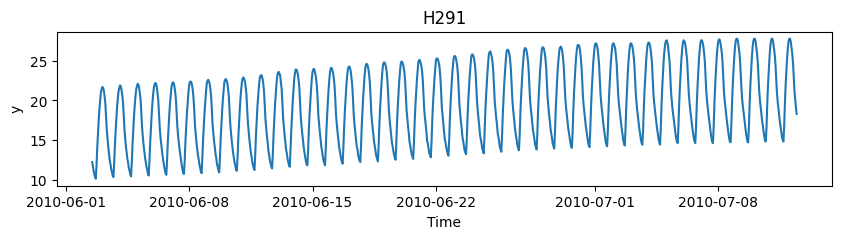

In [194]:
df_h291['time'] = pd.to_datetime(df_h291['time'])

plt.figure(figsize=(10, 2))

plt.plot(df_h291['time'], df_h291['y'], label='H291')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('H291')

plt.show()


In [195]:
# Aplicar la prueba de Dickey-Fuller
result = adfuller(df_h291["y"])

# Mostrar los resultados
print("Resultados de la Prueba de Dickey-Fuller Aumentada:")
print(f"Estadístico ADF: {result[0]}")
print(f"Valor p: {result[1]}")
print(f"Número de retardos usados: {result[2]}")
print(f"Número de observaciones: {result[3]}")
print("Valores críticos:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

# Interpretación del resultado
alpha = 0.05  # Nivel de significancia del 5%
if result[1] < alpha:
    print("\nConclusión: La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("\nConclusión: La serie NO es estacionaria (no se puede rechazar la hipótesis nula).")


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico ADF: -3.6295268959485147
Valor p: 0.0052209895363950366
Número de retardos usados: 22
Número de observaciones: 937
Valores críticos:
  1%: -3.4373481911362997
  5%: -2.864629502968925
  10%: -2.56841503507527

Conclusión: La serie es estacionaria (se rechaza la hipótesis nula).


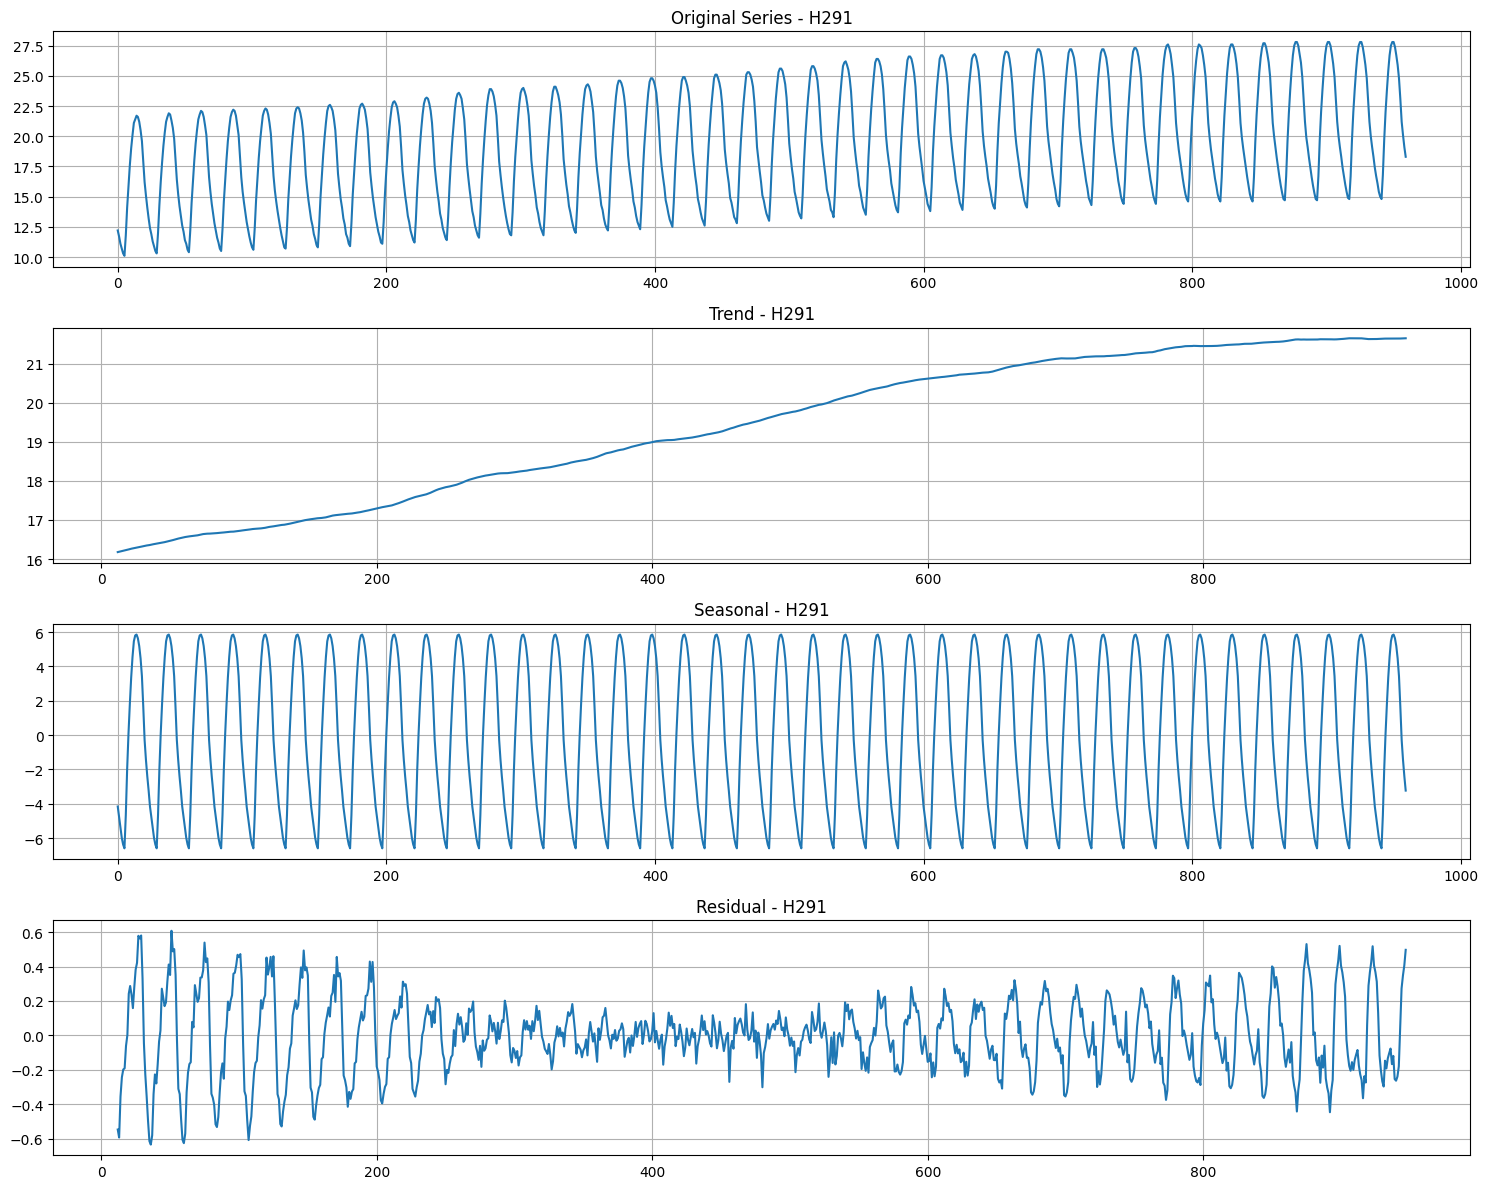

In [196]:
def plot_decomposition(series, series_name, period=24): #24 por que son por hora
    decomposition = seasonal_decompose(series, model='additive', period=period)

    # Crear subgráficos
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    titles = ["Original Series", "Trend", "Seasonal", "Residual"]
    components = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

    for ax, title, comp in zip(axes, titles, components):
        ax.plot(comp)
        ax.set_title(f"{title} - {series_name}")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Aplicar la descomposición estacional
plot_decomposition(df_h291["y"], "H291")


El test de dickey fuller me dijo que esta ya era estacionaria. También se puede observar que aunque si tiene una pendiente, no es tan pronunciada. La estacionalidad es fuerte y constante a lo largo de la serie. El residuio parece ser ruido blanco aleatorio. No será necesario transformarla. Sucede algo muy parecdia con la anterior.


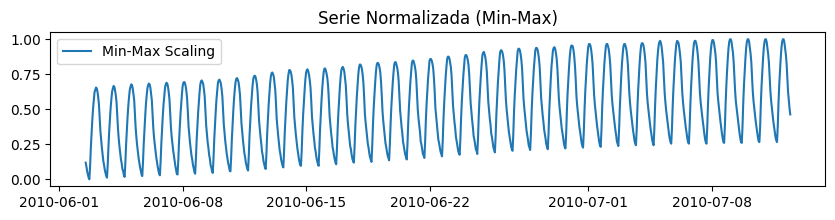

In [197]:
#normalizar los datos para las redes
scaler_minmax = MinMaxScaler()
df_h291['y_scaled'] = scaler_minmax.fit_transform(df_h291[['y']])

plt.figure(figsize=(10, 2))
plt.plot(df_h291['time'], df_h291['y_scaled'], label="Min-Max Scaling")
plt.title("Serie Normalizada (Min-Max)")
plt.legend()

## Division

In [198]:
# Definir los tamaños de los conjuntos (por ejemplo, 70% para entrenamiento, 15% para validación y 15% para prueba)
train_size = int(len(df_h291) * 0.7)
val_size = int(len(df_h291) * 0.15)
test_size = len(df_h291) - train_size - val_size

# Dividir la serie en entrenamiento, validación y prueba
train, val, test = df_h291[:train_size], df_h291[train_size:train_size+val_size], df_h291[train_size+val_size:]

# Verificar la división
print(f"Entrenamiento: {len(train)} | Validación: {len(val)} | Prueba: {len(test)}")


Entrenamiento: 672 | Validación: 144 | Prueba: 144


In [199]:
test["time"] = pd.to_datetime(test["time"])  

last_date = test["time"].iloc[-1]  # Última fecha en el conjunto de prueba
print(f"Última fecha de la prueba: {last_date}")


horizon = 48

#fechas de predicción a partir de la última fecha del conjunto de prueba
prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]

print("Fechas de predicción:")
print(prediction_dates)
print(len(prediction_dates))


Última fecha de la prueba: 2010-07-12 11:00:00
Fechas de predicción:
DatetimeIndex(['2010-07-12 12:00:00', '2010-07-12 13:00:00',
               '2010-07-12 14:00:00', '2010-07-12 15:00:00',
               '2010-07-12 16:00:00', '2010-07-12 17:00:00',
               '2010-07-12 18:00:00', '2010-07-12 19:00:00',
               '2010-07-12 20:00:00', '2010-07-12 21:00:00',
               '2010-07-12 22:00:00', '2010-07-12 23:00:00',
               '2010-07-13 00:00:00', '2010-07-13 01:00:00',
               '2010-07-13 02:00:00', '2010-07-13 03:00:00',
               '2010-07-13 04:00:00', '2010-07-13 05:00:00',
               '2010-07-13 06:00:00', '2010-07-13 07:00:00',
               '2010-07-13 08:00:00', '2010-07-13 09:00:00',
               '2010-07-13 10:00:00', '2010-07-13 11:00:00',
               '2010-07-13 12:00:00', '2010-07-13 13:00:00',
               '2010-07-13 14:00:00', '2010-07-13 15:00:00',
               '2010-07-13 16:00:00', '2010-07-13 17:00:00',
               '

/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/2284990760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["time"] = pd.to_datetime(test["time"])
/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/2284990760.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]


# H309

In [200]:
# Definir la fecha de inicio
start_date = pd.to_datetime("10-05-10 12:00", format="%d-%m-%y %H:%M")

# Crear un rango de fechas con una hora de diferencia para cada fila de H143
index = pd.date_range(start=start_date, periods=len(df_t["H309"]), freq="H")

# Asignar el nuevo índice de tiempo a la serie
df_h309 = df_t["H309"].copy()
df_h309.index = index

df_h309 = pd.DataFrame({"time": index, "y": df_t["H309"].values})
df_h309 =df_h309.dropna(subset=['y'])
df_h309


/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/370940607.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start_date, periods=len(df_t["H309"]), freq="H")


time     y
0   2010-05-10 12:00:00  12.4
1   2010-05-10 13:00:00  11.8
2   2010-05-10 14:00:00  11.3
3   2010-05-10 15:00:00  10.8
4   2010-05-10 16:00:00  10.5
..                  ...   ...
955 2010-06-19 07:00:00  25.6
956 2010-06-19 08:00:00  23.8
957 2010-06-19 09:00:00  22.2
958 2010-06-19 10:00:00  21.2
959 2010-06-19 11:00:00  20.3

[960 rows x 2 columns]

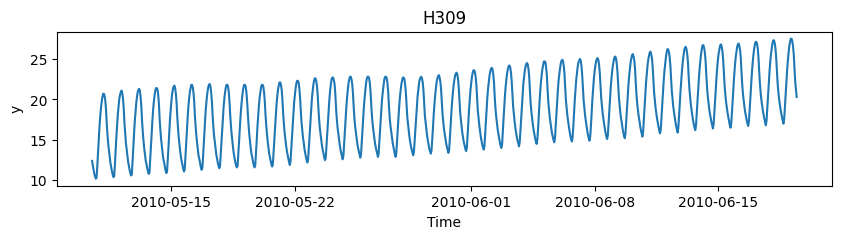

In [201]:
df_h309['time'] = pd.to_datetime(df_h309['time'])

plt.figure(figsize=(10, 2))

plt.plot(df_h309['time'], df_h309['y'], label='H309')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('H309')

plt.show()


In [202]:
# Aplicar la prueba de Dickey-Fuller
result = adfuller(df_h309["y"])

# Mostrar los resultados
print("Resultados de la Prueba de Dickey-Fuller Aumentada:")
print(f"Estadístico ADF: {result[0]}")
print(f"Valor p: {result[1]}")
print(f"Número de retardos usados: {result[2]}")
print(f"Número de observaciones: {result[3]}")
print("Valores críticos:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

# Interpretación del resultado
alpha = 0.05  # Nivel de significancia del 5%
if result[1] < alpha:
    print("\nConclusión: La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("\nConclusión: La serie NO es estacionaria (no se puede rechazar la hipótesis nula).")


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico ADF: 1.8931043378274421
Valor p: 0.9985168437882265
Número de retardos usados: 22
Número de observaciones: 937
Valores críticos:
  1%: -3.4373481911362997
  5%: -2.864629502968925
  10%: -2.56841503507527

Conclusión: La serie NO es estacionaria (no se puede rechazar la hipótesis nula).


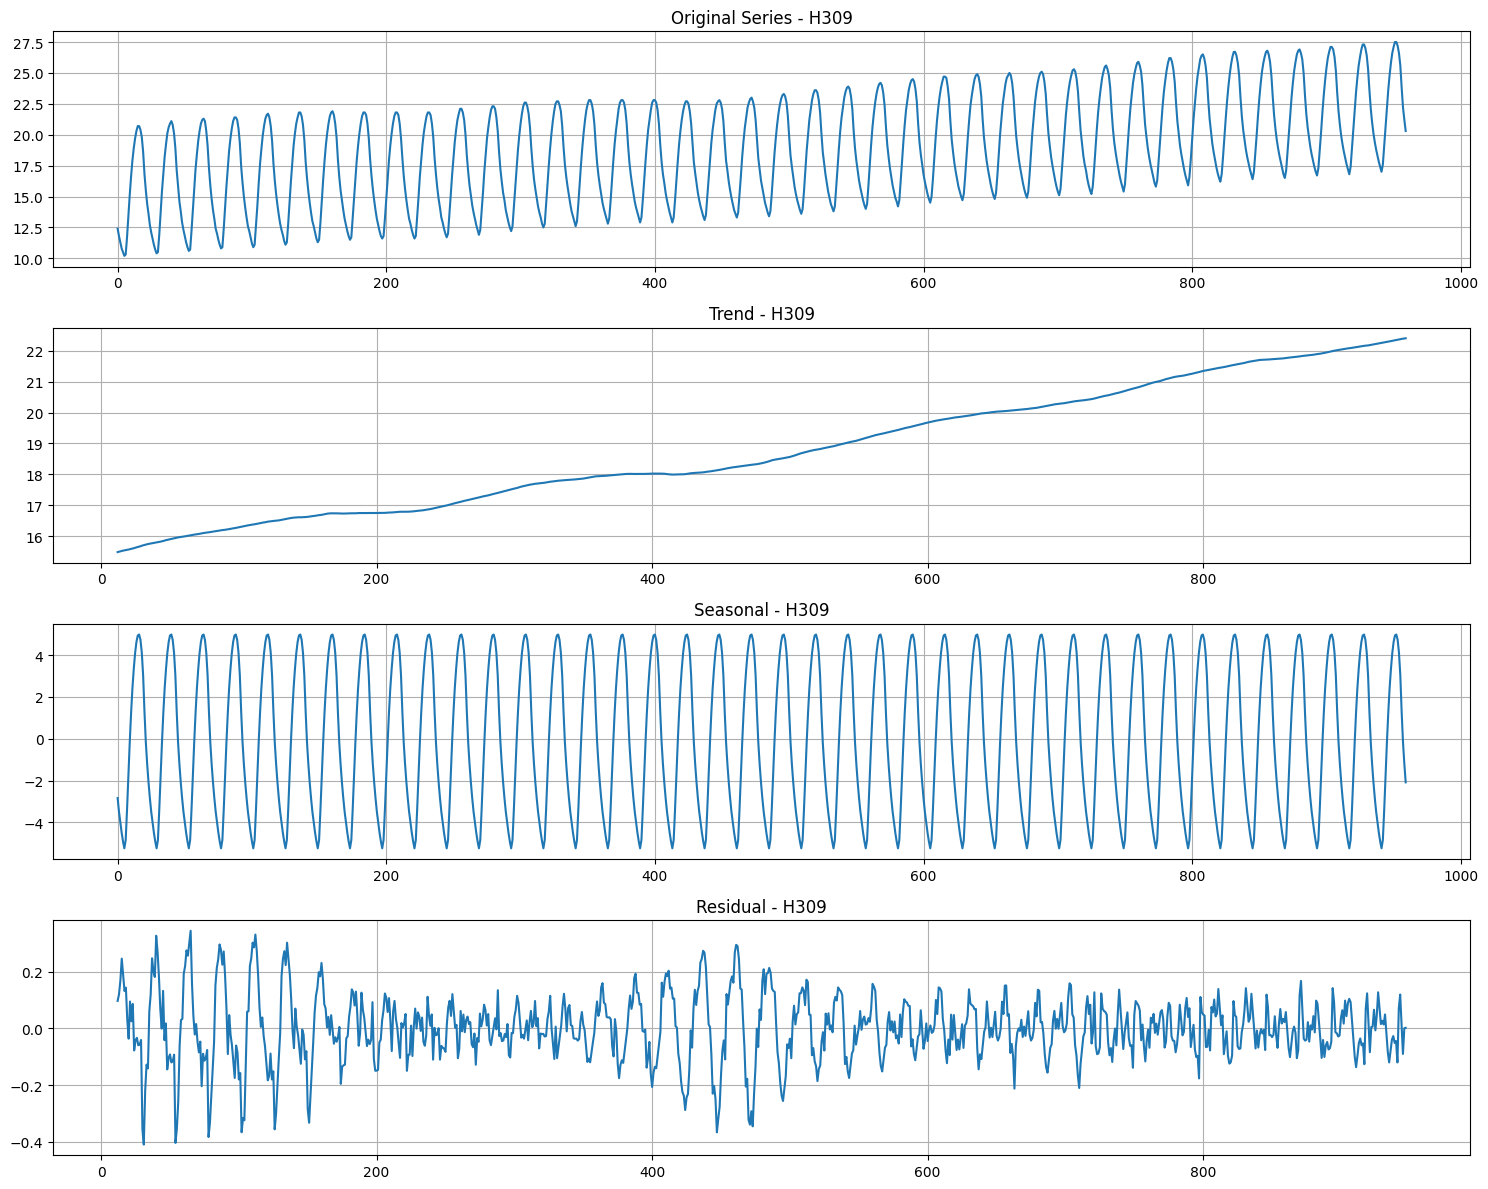

In [203]:
def plot_decomposition(series, series_name, period=24): #24 por que son por hora
    decomposition = seasonal_decompose(series, model='additive', period=period)

    # Crear subgráficos
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    titles = ["Original Series", "Trend", "Seasonal", "Residual"]
    components = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

    for ax, title, comp in zip(axes, titles, components):
        ax.plot(comp)
        ax.set_title(f"{title} - {series_name}")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Aplicar la descomposición estacional
plot_decomposition(df_h309["y"], "H309")


Se puede ver que tiene una tendencia creciente, y un patron estacional repetitivo. Esto al igual que el test de dickey fuller nos dice que no es estacionaria, ya que su media cambia a lo largo del tiempo. 

Para hacerla estacionaria, se podria eliminar la tendencia haciendo alguna diferenciación. 

El residuo, parece ser muy aleatorio. Tal vez podria mejorar con alguna transofrmaciòn. 


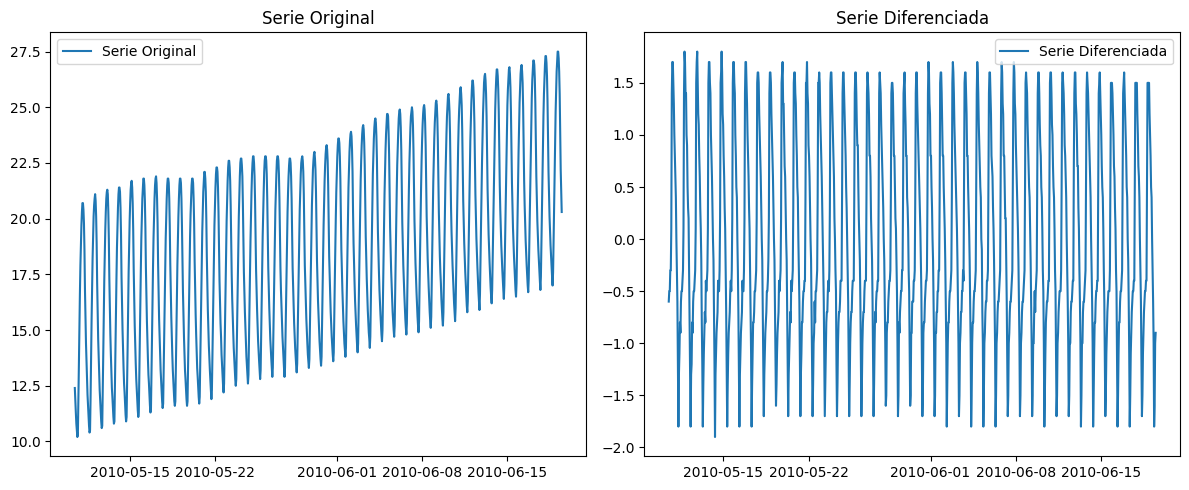

🔹 Resultado de Dickey-Fuller después de la diferenciación:
   - Estadístico: -40.26552325071792
   - P-valor: 0.0
   - Valores Críticos: {'1%': np.float64(-3.43735568849112), '5%': np.float64(-2.864632808981867), '10%': np.float64(-2.5684167960132225)}
La serie diferenciada es estacionaria (rechazamos H0)


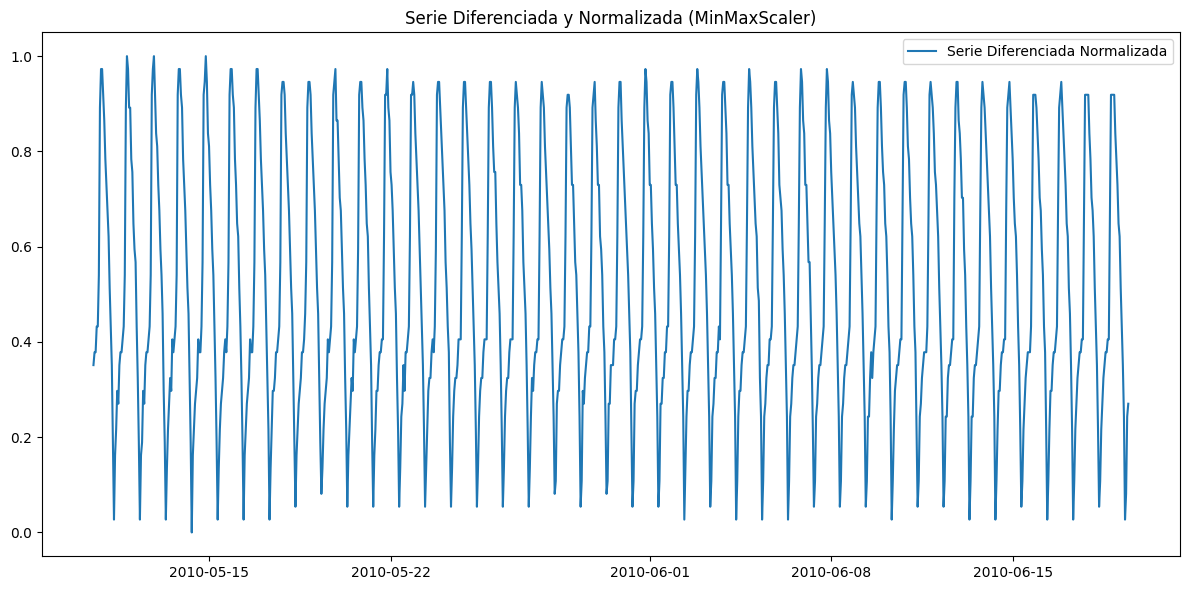

In [204]:
#diferenciacion
df_h309.set_index('time', inplace=True)

df_h309['y_diff'] = df_h309['y'].diff()

# Graficar la serie original y diferenciada
plt.figure(figsize=(12, 5))

# Serie original
plt.subplot(1, 2, 1)
plt.plot(df_h309.index, df_h309['y'], label='Serie Original')  # Usar el índice (fechas) para el eje x
plt.title('Serie Original')
plt.legend()

# Serie diferenciada
plt.subplot(1, 2, 2)
plt.plot(df_h309.index, df_h309['y_diff'], label='Serie Diferenciada')  # Usar el índice (fechas) para el eje x
plt.title('Serie Diferenciada')
plt.legend()

plt.tight_layout()
plt.show()

# Aplicar test de Dickey-Fuller para verificar estacionariedad
resultado = adfuller(df_h309['y_diff'].dropna())
print("🔹 Resultado de Dickey-Fuller después de la diferenciación:")
print(f"   - Estadístico: {resultado[0]}")
print(f"   - P-valor: {resultado[1]}")
print(f"   - Valores Críticos: {resultado[4]}")

# Evaluar si la serie diferenciada es estacionaria
if resultado[1] < 0.05:
    print("La serie diferenciada es estacionaria (rechazamos H0)")
else:
    print("La serie diferenciada NO es estacionaria (no rechazamos H0)")

# Normalizar la serie diferenciada utilizando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  
df_h309['y_diff_scaled'] = scaler.fit_transform(df_h309[['y_diff']])

# Graficar la serie diferenciada normalizada
plt.figure(figsize=(12, 6))
plt.plot(df_h309.index, df_h309['y_diff_scaled'], label='Serie Diferenciada Normalizada')
plt.title('Serie Diferenciada y Normalizada (MinMaxScaler)')
plt.legend()

plt.tight_layout()
plt.show()


In [205]:
# Definir los tamaños de los conjuntos (por ejemplo, 70% para entrenamiento, 15% para validación y 15% para prueba)
train_size = int(len(df_h309) * 0.7)
val_size = int(len(df_h309) * 0.15)
test_size = len(df_h309) - train_size - val_size

# Dividir la serie en entrenamiento, validación y prueba
train, val, test = df_h309[:train_size], df_h309[train_size:train_size+val_size], df_h309[train_size+val_size:]

# Verificar la división

print(f"Tamaño de entrenamiento: {len(train)}")
print(f"Tamaño de validación: {len(val)}")
print(f"Tamaño de prueba: {len(test)}")


Tamaño de entrenamiento: 672
Tamaño de validación: 144
Tamaño de prueba: 144


In [206]:
horizon = 48  # Puedes ajustar esto según necesites

# Obtener la última fecha de cada conjunto
train_last_date = train.index[-1]
val_last_date = val.index[-1]
test_last_date = test.index[-1]

# Generar las fechas futuras para el horizonte de predicción
train_pred_horizon = pd.date_range(start=train_last_date, periods=horizon + 1, freq='H')[1:]
val_pred_horizon = pd.date_range(start=val_last_date, periods=horizon + 1, freq='H')[1:]
test_pred_horizon = pd.date_range(start=test_last_date, periods=horizon + 1, freq='H')[1:]

# Mostrar resultados
print(f"Última fecha del conjunto de entrenamiento: {train_last_date}")
print(f"Horizonte de predicción para entrenamiento:\n{train_pred_horizon}")

print(f"\nÚltima fecha del conjunto de validación: {val_last_date}")
print(f"Horizonte de predicción para validación:\n{val_pred_horizon}")

print(f"\nÚltima fecha del conjunto de prueba: {test_last_date}")
print(f"Horizonte de predicción para prueba:\n{test_pred_horizon}")

Última fecha del conjunto de entrenamiento: 2010-06-07 11:00:00
Horizonte de predicción para entrenamiento:
DatetimeIndex(['2010-06-07 12:00:00', '2010-06-07 13:00:00',
               '2010-06-07 14:00:00', '2010-06-07 15:00:00',
               '2010-06-07 16:00:00', '2010-06-07 17:00:00',
               '2010-06-07 18:00:00', '2010-06-07 19:00:00',
               '2010-06-07 20:00:00', '2010-06-07 21:00:00',
               '2010-06-07 22:00:00', '2010-06-07 23:00:00',
               '2010-06-08 00:00:00', '2010-06-08 01:00:00',
               '2010-06-08 02:00:00', '2010-06-08 03:00:00',
               '2010-06-08 04:00:00', '2010-06-08 05:00:00',
               '2010-06-08 06:00:00', '2010-06-08 07:00:00',
               '2010-06-08 08:00:00', '2010-06-08 09:00:00',
               '2010-06-08 10:00:00', '2010-06-08 11:00:00',
               '2010-06-08 12:00:00', '2010-06-08 13:00:00',
               '2010-06-08 14:00:00', '2010-06-08 15:00:00',
               '2010-06-08 16:00:00', 

/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/377691022.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train_pred_horizon = pd.date_range(start=train_last_date, periods=horizon + 1, freq='H')[1:]
/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/377691022.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  val_pred_horizon = pd.date_range(start=val_last_date, periods=horizon + 1, freq='H')[1:]
/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/377691022.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_pred_horizon = pd.date_range(start=test_last_date, periods=horizon + 1, freq='H')[1:]


# H366

In [207]:
# Definir la fecha de inicio
start_date = pd.to_datetime("01-01-17 12:00", format="%d-%m-%y %H:%M")

# Crear un rango de fechas con una hora de diferencia para cada fila de H143
index = pd.date_range(start=start_date, periods=len(df_t["H366"]), freq="H")

# Asignar el nuevo índice de tiempo a la serie
df_h366 = df_t["H366"].copy()
df_h366.index = index

df_h366 = pd.DataFrame({"time": index, "y": df_t["H366"].values})
df_h366 =df_h366.dropna(subset=['y'])
df_h366


/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/1167168997.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=start_date, periods=len(df_t["H366"]), freq="H")


time     y
0   2017-01-01 12:00:00  39.0
1   2017-01-01 13:00:00  31.0
2   2017-01-01 14:00:00  23.0
3   2017-01-01 15:00:00  20.0
4   2017-01-01 16:00:00  26.0
..                  ...   ...
955 2017-02-10 07:00:00  47.0
956 2017-02-10 08:00:00  45.0
957 2017-02-10 09:00:00  37.0
958 2017-02-10 10:00:00  43.0
959 2017-02-10 11:00:00  76.0

[960 rows x 2 columns]

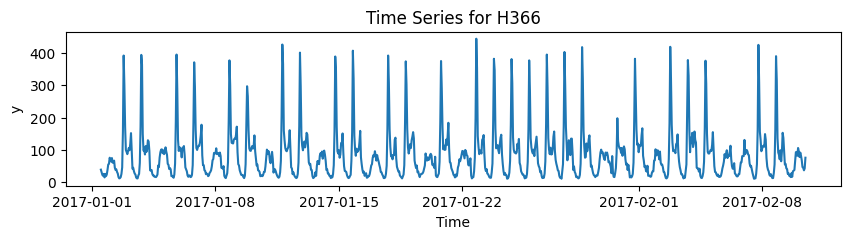

In [ ]:
df_h366['time'] = pd.to_datetime(df_h366['time'])

plt.figure(figsize=(10, 2))

plt.plot(df_h366['time'], df_h366['y'], label='H366')
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Time Series for H366')

plt.show()


In [209]:
# Aplicar la prueba de Dickey-Fuller
result = adfuller(df_h366["y"])

# Mostrar los resultados
print("Resultados de la Prueba de Dickey-Fuller Aumentada:")
print(f"Estadístico ADF: {result[0]}")
print(f"Valor p: {result[1]}")
print(f"Número de retardos usados: {result[2]}")
print(f"Número de observaciones: {result[3]}")
print("Valores críticos:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

# Interpretación del resultado
alpha = 0.05  # Nivel de significancia del 5%
if result[1] < alpha:
    print("\nConclusión: La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("\nConclusión: La serie NO es estacionaria (no se puede rechazar la hipótesis nula).")


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico ADF: -4.829307862377842
Valor p: 4.778330183181506e-05
Número de retardos usados: 22
Número de observaciones: 937
Valores críticos:
  1%: -3.4373481911362997
  5%: -2.864629502968925
  10%: -2.56841503507527

Conclusión: La serie es estacionaria (se rechaza la hipótesis nula).


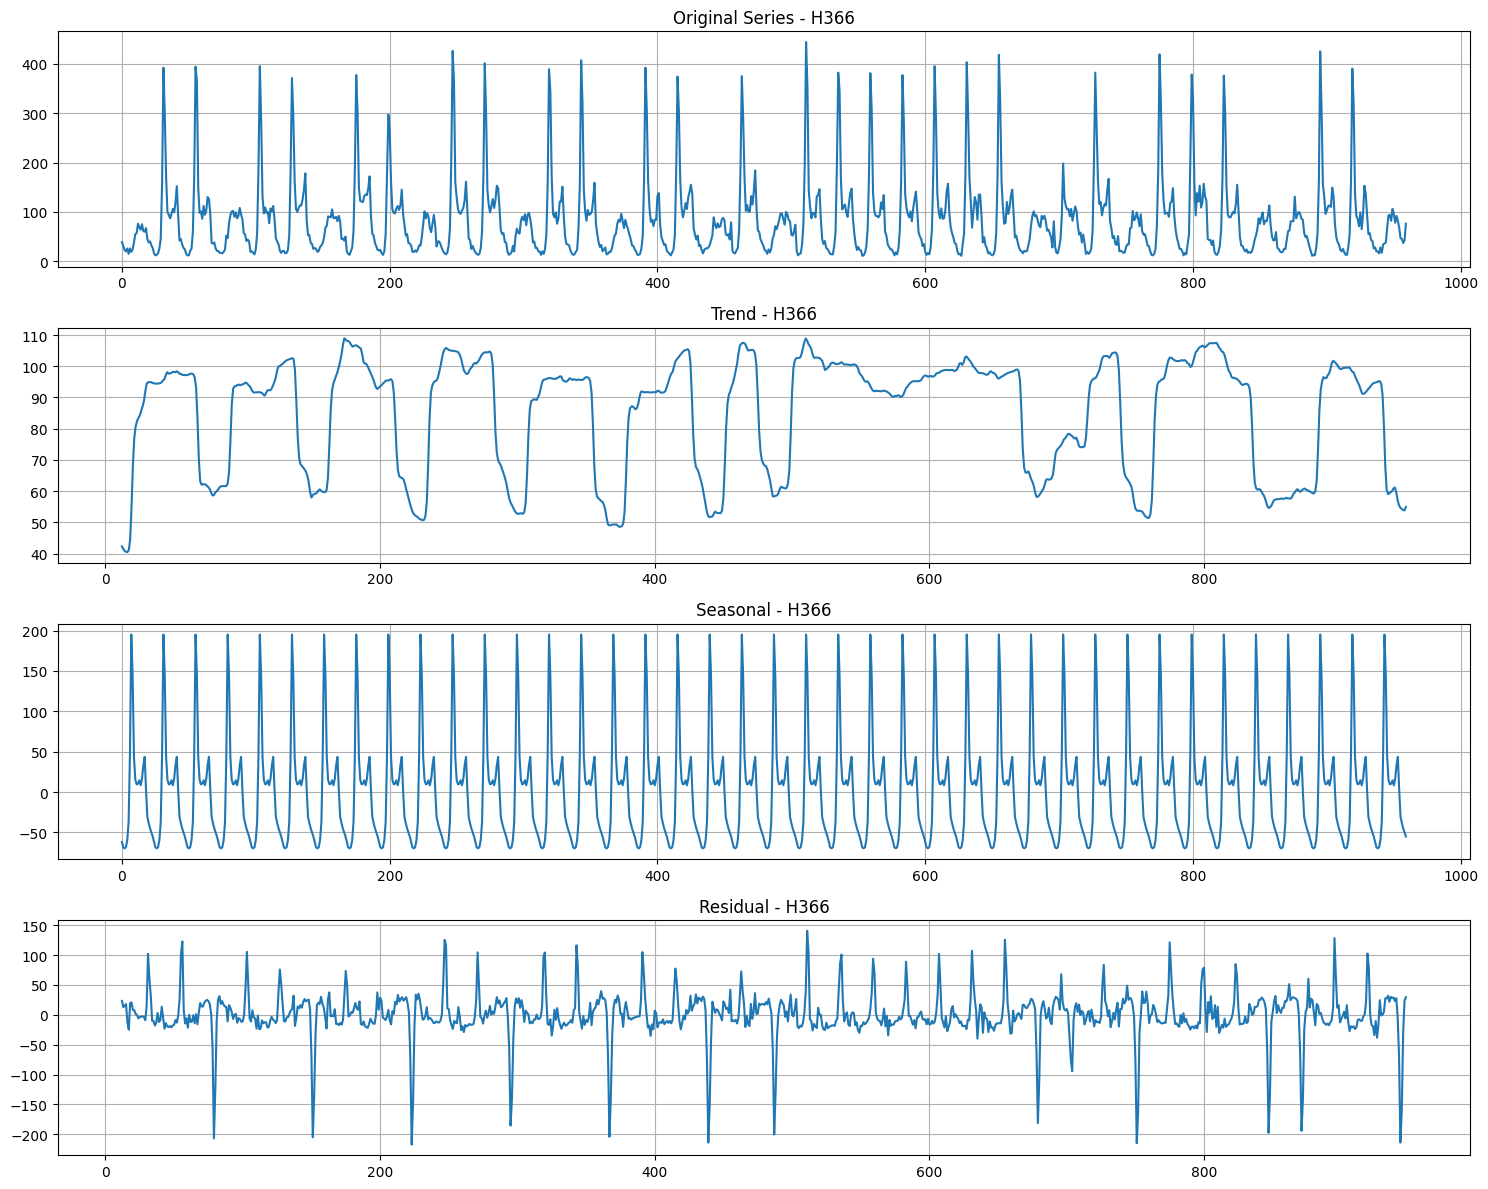

In [ ]:
def plot_decomposition(series, series_name, period=24): #24 por que son por hora
    decomposition = seasonal_decompose(series, model='additive', period=period)

    # Crear subgráficos
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    titles = ["Original Series", "Trend", "Seasonal", "Residual"]
    components = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

    for ax, title, comp in zip(axes, titles, components):
        ax.plot(comp)
        ax.set_title(f"{title} - {series_name}")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# Aplicar la descomposición estacional
plot_decomposition(df_h366["y"], "H366")


NO tiene una tendencia lineal simple, tiene cambios escalonados. Tiene picos muy similares en la parte de estacionalidad, al igual que el test de dickey fuller que dice que es una serie estacional. 



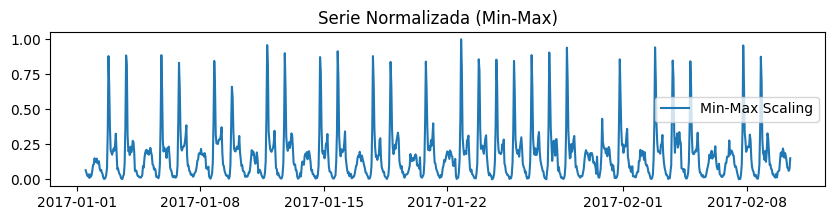

In [211]:
#normalizar los datos para las redes
scaler_minmax = MinMaxScaler()
df_h366['y_scaled'] = scaler_minmax.fit_transform(df_h366[['y']])

plt.figure(figsize=(10, 2))
plt.plot(df_h366['time'], df_h366['y_scaled'], label="Min-Max Scaling")
plt.title("Serie Normalizada (Min-Max)")
plt.legend()

# Division

In [212]:
# Definir los tamaños de los conjuntos (por ejemplo, 70% para entrenamiento, 15% para validación y 15% para prueba)
train_size = int(len(df_h366) * 0.7)
val_size = int(len(df_h366) * 0.15)
test_size = len(df_h366) - train_size - val_size

# Dividir la serie en entrenamiento, validación y prueba
train, val, test = df_h366[:train_size], df_h366[train_size:train_size+val_size], df_h366[train_size+val_size:]

# Verificar la división
print(f"Entrenamiento: {len(train)} | Validación: {len(val)} | Prueba: {len(test)}")


Entrenamiento: 672 | Validación: 144 | Prueba: 144


In [213]:
test["time"] = pd.to_datetime(test["time"])  

last_date = test["time"].iloc[-1]  # Última fecha en el conjunto de prueba
print(f"Última fecha de la prueba: {last_date}")

horizon = 48

#fechas de predicción a partir de la última fecha del conjunto de prueba
prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]

print("Fechas de predicción:")
print(prediction_dates)
print(len(prediction_dates))


Última fecha de la prueba: 2017-02-10 11:00:00
Fechas de predicción:
DatetimeIndex(['2017-02-10 12:00:00', '2017-02-10 13:00:00',
               '2017-02-10 14:00:00', '2017-02-10 15:00:00',
               '2017-02-10 16:00:00', '2017-02-10 17:00:00',
               '2017-02-10 18:00:00', '2017-02-10 19:00:00',
               '2017-02-10 20:00:00', '2017-02-10 21:00:00',
               '2017-02-10 22:00:00', '2017-02-10 23:00:00',
               '2017-02-11 00:00:00', '2017-02-11 01:00:00',
               '2017-02-11 02:00:00', '2017-02-11 03:00:00',
               '2017-02-11 04:00:00', '2017-02-11 05:00:00',
               '2017-02-11 06:00:00', '2017-02-11 07:00:00',
               '2017-02-11 08:00:00', '2017-02-11 09:00:00',
               '2017-02-11 10:00:00', '2017-02-11 11:00:00',
               '2017-02-11 12:00:00', '2017-02-11 13:00:00',
               '2017-02-11 14:00:00', '2017-02-11 15:00:00',
               '2017-02-11 16:00:00', '2017-02-11 17:00:00',
               '

/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/3278927113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["time"] = pd.to_datetime(test["time"])
/var/folders/vj/k67r6tzn6k3gd90ph1hz0kbr0000gn/T/ipykernel_23517/3278927113.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_dates = pd.date_range(start=last_date, periods=horizon + 1, freq='H')[1:]
